# Задача

**Описание**
- На основе данных построить рекомендательную систему релевантных треков для пользователей и оценить качесвто

**Метрика**
- NDCG@20

**Задачи**
- EDA
- Pipline обучения модели: data processing, feauture engineering, модель, выбор loss, оценка модели
- Финальная метрика

### Импорт библиотек + настройка стилей

In [2]:
# Работа с данными
import pandas as pd
import numpy as np
import joblib

# Посмотроение графиков и визуализация
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Игнорирование всех предупреждений
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ndcg_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


import catboost
from catboost import CatBoostClassifier
from catboost import Pool 

In [6]:
# Настройка стилей
# Изменение размера графика
plt.rcParams['figure.figsize'] = (16,8)
# Изменение размера заголовка
plt.rcParams['axes.titlesize'] = 18
# Изменение начертания заголовка
plt.rcParams['axes.titleweight'] = 'bold'

# Настройка стилей для информации поверх графика
bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

### Загрузка данных

In [3]:
df_train = pd.read_csv('train.csv')
df_songs = pd.read_csv('songs.csv')
df_members = pd.read_csv('members.csv')
df_song_extra = pd.read_csv('song_extra_info.csv')

test_df = pd.read_csv('test.csv')

In [8]:
# Размерность набора данных
print(f'Размер набора данных:{df_train.shape}')
df_train.head()

Размер набора данных:(7377418, 6)


msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              Explore  online-playlist       1  
1  Local playlist more   local-playlist       1  
2  Local playlist more   local-playlist       1  
3  Local playlist more   local-playlist       1  
4              Explore  online-playlist       1

В наборе данных имеем следующие столбцы
1. msno - id пользователя - могут повторяться, это указывает, что у конкретного пользователя есть история прослушиваний треков на платформе
2. song_id - id песни, которую слушал пользвователь

следовательно мы можем дополнить этот набор данных данными из других файлов - объеденив по id 

In [9]:
# Объединение наборов данных в один набор данных
# Дополним набор данных признаками песен (дополнительные данных из файла songs.csv)
df = pd.merge(df_train,df_songs, on = 'song_id', how = 'left')

# Дополним набор данных признаками пользователя (дополнительные данные из файла members.csv)
df = pd.merge(df, df_members, on = 'msno', how = 'left')

# Дополним набор данных названием и кодом isrc песни (дополнительные данные из файла song_extra_info.csv)
df = pd.merge(df, df_song_extra, on = 'song_id', how = 'left')

# Просмотр набора данных
print(f'Размер дополненного набора данных: {df.shape}')
df.head()

Размер дополненного набора данных: (7377418, 20)


msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist       1     206471.0       359   
1  Local playlist more   local-playlist       1     284584.0      1259   
2  Local playlist more   local-playlist       1     225396.0      1259   
3  Local playlist more   local-playlist       1     255512.0      1019   
4              Explore  online-playlist       1     187802.0      1011   

       artist_name                                 composer lyricist  \
0         Bastille                     Dan Smith| Mark Crew      NaN   
1  Various Artists                                      NaN      NaN   
2              Nas     N. Jones、W. Adams、J. Lordan、D. Ingle      NaN   
3         Soundway                            Kwadwo Donkoh      NaN   
4      Brett Young  Brett Young| Kelly Archer| Justin Ebach      NaN   

   language  city  bd  gender  registered_via  registration_init_time  \
0      52.0     1   0     NaN               7                20120102   
1      52.0    13  24  female               9                20110525   
2      52.0    13  24  female               9                20110525   
3      -1.0    13  24  female               9                20110525   
4      52.0     1   0     NaN               7                20120102   

   expiration_date                                     name          isrc  
0         20171005                               Good Grief  GBUM71602854  
1         20170911                       Lords of Cardboard  US3C69910183  
2         20170911  Hip Hop Is Dead(Album Version (Edited))  USUM70618761  
3         20170911                             Disco Africa  GBUQH1000063  
4         20171005                        Sleep Without You  QM3E21606003

In [6]:
# Новый порядок колонок 
new_order = ['msno', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date',
             'song_id', 'name', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'isrc',
             'source_system_tab', 'source_screen_name', 'source_type', 'target']

df = df[new_order]
df.head(2)

msno  city  bd  gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0     NaN   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24  female   

   registered_via  registration_init_time  expiration_date  \
0               7                20120102         20171005   
1               9                20110525         20170911   

                                        song_id                name  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          Good Grief   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=  Lords of Cardboard   

   song_length genre_ids      artist_name              composer lyricist  \
0     206471.0       359         Bastille  Dan Smith| Mark Crew      NaN   
1     284584.0      1259  Various Artists                   NaN      NaN   

   language          isrc source_system_tab   source_screen_name  \
0      52.0  GBUM71602854           explore              Explore   
1      52.0  US3C69910183        my library  Local playlist more   

       source_type  target  
0  online-playlist       1  
1   local-playlist       1

Сделал новый порядок колонок чтобы была следующая логика следования 
- сначала id пользователя, после которого идет информация о самом пользователе из дополнительных файлов
- после идет id трека который он послушал, после чего информация об этом треке из дополнительных файлов
- после идет информация как пользователь взаимодействует с приложением (source_system_tab,source_screen_name, source_typ)
- target - релевантность трека - 1 - понравился (будем считать что пользователь поставил лайк этому треку) и 0 - нерелевантный

### Функция для получения информации из набора данных

In [7]:
def info_data(df):
    """
    df - набор данных для которого извлекается информация
    """
    # создаем набор данных для отображения информации
    info = pd.DataFrame()

    # Индексы - каждый столбец в наборе данных
    info.index = df.columns
    # dtypes - тип данных столбца
    info['dtypes'] = df.dtypes
    # count_nan - количество пропущенных значений в наборе данных
    info['count_nan'] = df.isna().sum()
    # proc_nan - процент пропущенных значения (для отображения относительной величины)
    info['proc_nan'] =  round((info['count_nan'] / (df.index.max() + 1)) * 100 ,3)
    # nunique - количество уникальных элементов в наборе денных
    info['nunique'] = df.nunique()

    # Добавление описательной статистики
    describe = df.describe().T
    info = pd.concat([info, describe], axis = 1)
    
    return info

In [8]:
info_data(df)

dtypes  count_nan  proc_nan  nunique      count  \
msno                     object          0     0.000    30755        NaN   
city                      int64          0     0.000       21  7377418.0   
bd                        int64          0     0.000       92  7377418.0   
gender                   object    2961479    40.142        2        NaN   
registered_via            int64          0     0.000        5  7377418.0   
registration_init_time    int64          0     0.000     3811  7377418.0   
expiration_date           int64          0     0.000     1395  7377418.0   
song_id                  object          0     0.000   359966        NaN   
name                     object       1457     0.020   234144        NaN   
song_length             float64        114     0.002    60266  7377304.0   
genre_ids                object     118455     1.606      572        NaN   
artist_name              object        114     0.002    40582        NaN   
composer                 object    1675706    22.714    76064        NaN   
lyricist                 object    3178812    43.088    33887        NaN   
language                float64        150     0.002       10  7377268.0   
isrc                     object     577858     7.833   269760        NaN   
source_system_tab        object      24849     0.337        8        NaN   
source_screen_name       object     414804     5.623       20        NaN   
source_type              object      21539     0.292       12        NaN   
target                    int64          0     0.000        2  7377418.0   

                                mean           std         min         25%  \
msno                             NaN           NaN         NaN         NaN   
city                    7.511399e+00      6.641625         1.0         1.0   
bd                      1.753927e+01     21.554470       -43.0         0.0   
gender                           NaN           NaN         NaN         NaN   
registered_via          6.794068e+00      2.275774         3.0         4.0   
registration_init_time  2.012810e+07  30172.810633  20040326.0  20110705.0   
expiration_date         2.017157e+07   3869.830750  19700101.0  20170911.0   
song_id                          NaN           NaN         NaN         NaN   
name                             NaN           NaN         NaN         NaN   
song_length             2.451210e+05  67344.711084      1393.0    214726.0   
genre_ids                        NaN           NaN         NaN         NaN   
artist_name                      NaN           NaN         NaN         NaN   
composer                         NaN           NaN         NaN         NaN   
lyricist                         NaN           NaN         NaN         NaN   
language                1.860933e+01     21.176805        -1.0         3.0   
isrc                             NaN           NaN         NaN         NaN   
source_system_tab                NaN           NaN         NaN         NaN   
source_screen_name               NaN           NaN         NaN         NaN   
source_type                      NaN           NaN         NaN         NaN   
target                  5.035171e-01      0.499988         0.0         0.0   

                               50%         75%         max  
msno                           NaN         NaN         NaN  
city                           5.0        13.0        22.0  
bd                            21.0        29.0      1051.0  
gender                         NaN         NaN         NaN  
registered_via                 7.0         9.0        13.0  
registration_init_time  20131023.0  20151022.0  20170131.0  
expiration_date         20170926.0  20171006.0  20201017.0  
song_id                        NaN         NaN         NaN  
name                           NaN         NaN         NaN  
song_length               241812.0    272160.0  10851706.0  
genre_ids                      NaN         NaN         NaN  
artist_name                    NaN         NaN         Na

- всего пользователей на платформе, которые слушают музыку - 30755
- охват городов, в которых проживают пользователи - 21 город
- в столбце bd, который отражает возраст существуют отрицательные значения, и превышающие допустимые (не может быть, что человеку 1051 год)
- в столбце пол пользователя - пропущено 40% данных, в столбце lyricist также пропущено > 40% данных
- существует 5 способов регистрации
- пользователи плафтормы послушали 359966 уникальных треков
- registration_init_time - тип данных int который надо разбить на год, месяц, и день
- expiration_date - топ данных int - сделать тоже самое что и со столбцом registration_init_time
- в наборе данных существуют песни на 10 различных языках

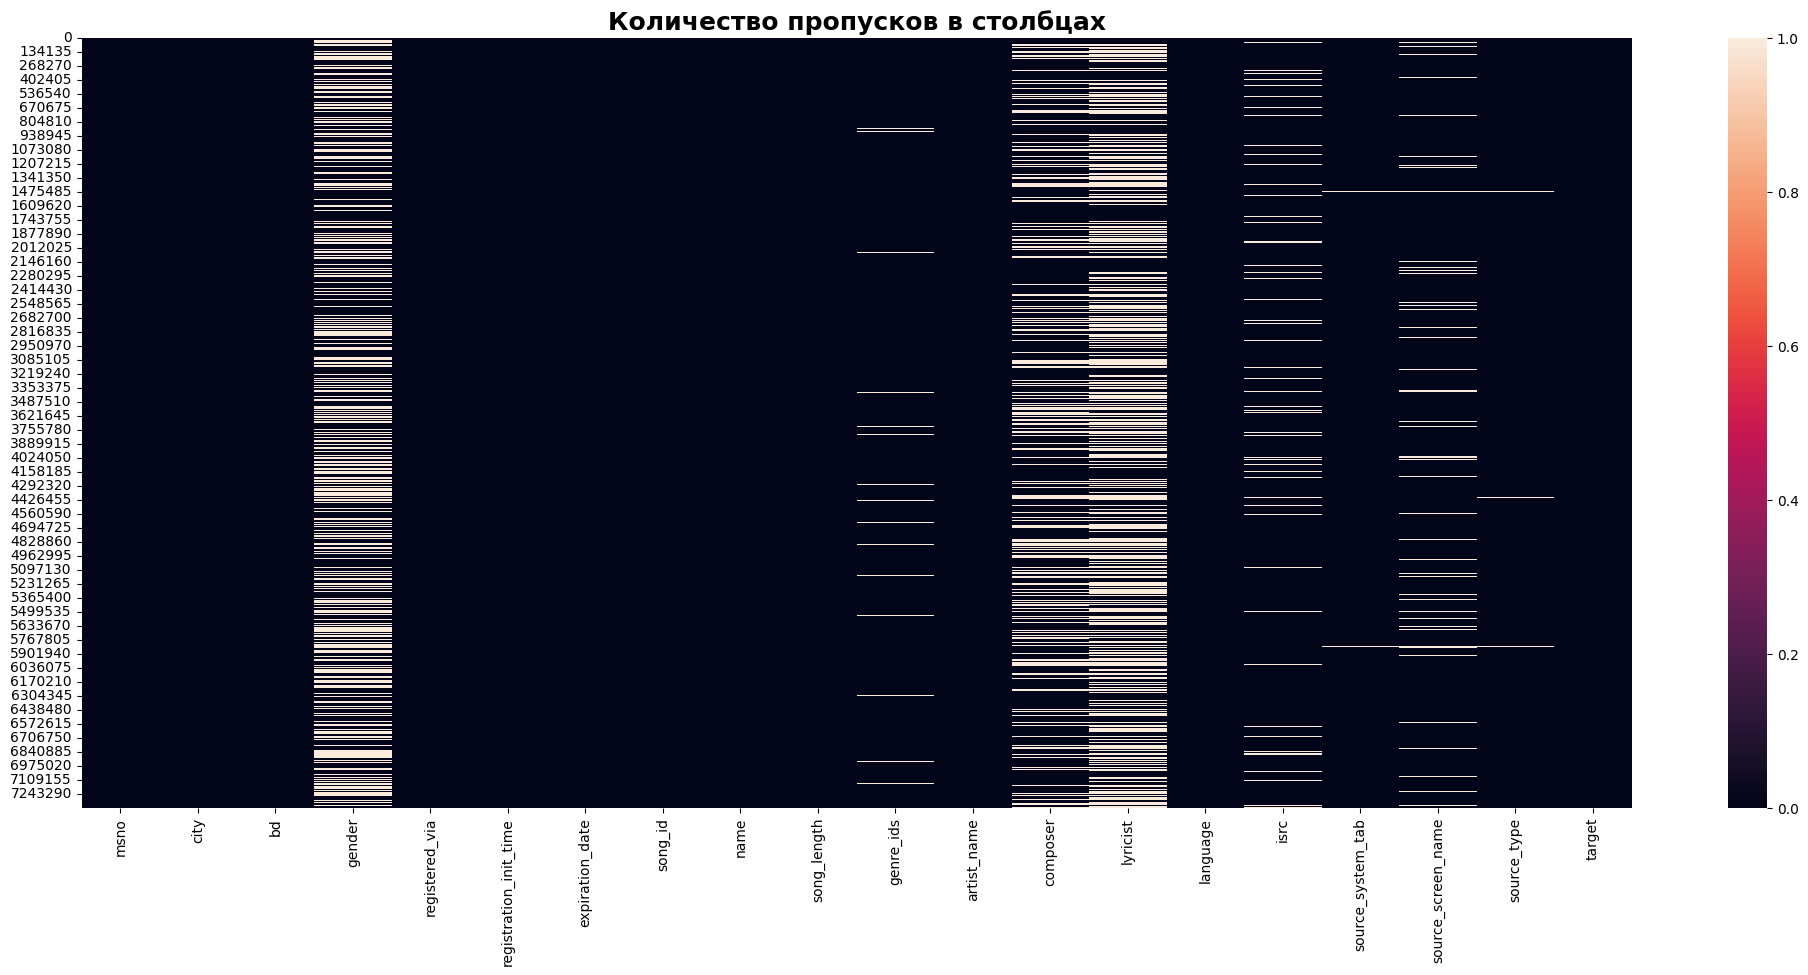

In [9]:
plt.figure(figsize=(25,10))

sns.heatmap(df.isna())
plt.title('Количество пропусков в столбцах')

plt.show()

# Зполнение пропусков и изменение некорректных значений признаков

### Замена некорректных значений в признаке bd (возраст)

In [10]:
# Какие есть некорректные значения (больше 100)
df[df['bd'] >= 100]['bd'].unique()

array([ 111,  131,  103, 1030,  105,  107,  931,  144,  112,  106,  102,
       1051])

In [11]:
# Какие есть некорректные значения (меньше 0)
df[df['bd'] < 0]['bd'].unique()

array([-43, -38])

In [12]:
# Процент нулей в признаке с возрастом (0 - неуказанные значения)
df[df['bd'] == 0]['bd'].count() / df['bd'].count()

0.39858104827461316

- значения возраста не могут быть больше 100 - тем более возраст не может быть равен 1051 и подобным значениям
- мы имеем 12 некорректных значений, которые больше 100
- 2 некорректных значения - которые меньше 0
- большинство значений данной переменной (39%) - это значение 0 - что указывает на то что пользователь скорее всего не ввел свои данные о возрасте или просто пропустил этот пункт
---
Для исправления некорректных значений - заменим медианным значением возраста

In [13]:
# Заменяем некорректные значения на NaN - чтобы дальше заполнить NaN медианными значениями
df.loc[(df['bd'] < 0) | (df['bd'] > 99), 'bd'] = np.nan

In [14]:
df['bd'].isna().sum()

6703

Видим, что появились значения NaN в столбце, в котором их не было - следовательно нам теперь надо заполнить эти значения медианным значением, как и предполагалось ранее

In [15]:
# Возьмем медианное значение среди корректных значений (которые больше 0 и меньше 100)
median = df[(df['bd'] > 0) & (df['bd'] < 100)]['bd'].median()
print('Медианное значение возраста среди корректных пользователей =', median)

# Заменим значения NaN на медианные значения
df['bd'] = df['bd'].fillna(median)

Медианное значение возраста среди корректных пользователей = 27.0


In [16]:
df['bd'].isna().sum()

0

После заполнения медианным значением - у нас не осталось пропущенных строк в признаке - теперь мы имеем 2 категории в этом столбце 
- значение 0, если значение возраста незаполненно или пропущено при регистрации
- корректное значение возраста - в диапазоне от 1 до 99

### Заполнение пропусков значением unknown

Так как у нас есть такие столбцы, которые просто нельзя заполнить каким то средним, медианным или популярным значением (например такие признаки как название треки, или имя исполнителя) - то вместо удаления этих объектов (потому что мы можем потерять данные, которые нужны нам для дальнейших рекомендаций) - мы будем заполнять эти значения - значениями unknown - отсутствие данного значения

---
К такому заполнению относятся следующие признаки 
- gender - то есть мы выделим отдельный класс для пола пользователя - мужчина, женщина и неуказанный пол
- name - вместо удаления строк, с отсутствием названия трека - ставим значение отсутствия названия, так как при удалении мы терям определенную историю пользователя по прослушанным трекам, а так как может попасться пользователь, который только недавно зашел на платформу и у него мало прослушанных треков - мы удалим данные из его истории, которых и так меньше относительно пользователей, которые давно на платформе (длительность нахождения на платформе будет рассмотрено в EDA)
- genre_ids
- artist_name - тоже будем указывать значение неизветво - если не указано имя артиста по причине, которую описывал в признаке name
- composer
- isrc
- lyricist
- language
- source_system_tab
- source_screen_name
- source_type

заполняю значениям unknown - потому что в песне не указаны эти данные и следовательно я оставляю этот паттерн, вместо замены значений NaN на значения по типу медианного или заполнениями значениями по определенной группе

In [17]:
# Список колонок, в которых значение NaN будем заменять на значение unknown
columns_unknown = ['gender', 'name', 'genre_ids', 'artist_name', 'composer', 'isrc', 
                   'lyricist', 'source_system_tab', 'source_screen_name', 'source_type']

# Вывод значений NaN для указаных столбцов
df[columns_unknown].isna().sum()

gender                2961479
name                     1457
genre_ids              118455
artist_name               114
composer              1675706
isrc                   577858
lyricist              3178812
source_system_tab       24849
source_screen_name     414804
source_type             21539
dtype: int64

In [18]:
# цикл для заполнения
for col in columns_unknown:
    df[col] = df[col].fillna('unknown')

In [19]:
df[columns_unknown].isna().sum()

gender                0
name                  0
genre_ids             0
artist_name           0
composer              0
isrc                  0
lyricist              0
source_system_tab     0
source_screen_name    0
source_type           0
dtype: int64

После заполнения не осталось пропущенных значений, следовательно значения NaN заменились на значения unknown (сделал проверку после заполнения)

### Заполнение значений признаков song_length, language

Так как значения длительности трека также отсутствуют в данных - заменим NaN на значение 0

In [20]:
# Список признаков, в которых NaN будем заполнять значениями 0
zero_columns = ['song_length', 'language']

df[zero_columns].isna().sum()

song_length    114
language       150
dtype: int64

In [21]:
# Цикл для заполнения
for col in zero_columns:
    df[col] = df[col].fillna(0)

In [22]:
df[zero_columns].isna().sum()

song_length    0
language       0
dtype: int64

(Проверка) - после заполнения значений не осталось значений NaN

### Вывод информации о наборе данных после заполнения пропусков и изменении некорректных значений 

In [23]:
info_data(df)

dtypes  count_nan  proc_nan  nunique      count  \
msno                     object          0       0.0    30755        NaN   
city                      int64          0       0.0       21  7377418.0   
bd                      float64          0       0.0       78  7377418.0   
gender                   object          0       0.0        3        NaN   
registered_via            int64          0       0.0        5  7377418.0   
registration_init_time    int64          0       0.0     3811  7377418.0   
expiration_date           int64          0       0.0     1395  7377418.0   
song_id                  object          0       0.0   359966        NaN   
name                     object          0       0.0   234144        NaN   
song_length             float64          0       0.0    60267  7377418.0   
genre_ids                object          0       0.0      573        NaN   
artist_name              object          0       0.0    40583        NaN   
composer                 object          0       0.0    76064        NaN   
lyricist                 object          0       0.0    33887        NaN   
language                float64          0       0.0       11  7377418.0   
isrc                     object          0       0.0   269761        NaN   
source_system_tab        object          0       0.0        9        NaN   
source_screen_name       object          0       0.0       21        NaN   
source_type              object          0       0.0       13        NaN   
target                    int64          0       0.0        2  7377418.0   

                                mean           std         min         25%  \
msno                             NaN           NaN         NaN         NaN   
city                    7.511399e+00      6.641625         1.0         1.0   
bd                      1.727239e+01     15.572056         0.0         0.0   
gender                           NaN           NaN         NaN         NaN   
registered_via          6.794068e+00      2.275774         3.0         4.0   
registration_init_time  2.012810e+07  30172.810633  20040326.0  20110705.0   
expiration_date         2.017157e+07   3869.830750  19700101.0  20170911.0   
song_id                          NaN           NaN         NaN         NaN   
name                             NaN           NaN         NaN         NaN   
song_length             2.451172e+05  67351.083664         0.0    214726.0   
genre_ids                        NaN           NaN         NaN         NaN   
artist_name                      NaN           NaN         NaN         NaN   
composer                         NaN           NaN         NaN         NaN   
lyricist                         NaN           NaN         NaN         NaN   
language                1.860895e+01     21.176756        -1.0         3.0   
isrc                             NaN           NaN         NaN         NaN   
source_system_tab                NaN           NaN         NaN         NaN   
source_screen_name               NaN           NaN         NaN         NaN   
source_type                      NaN           NaN         NaN         NaN   
target                  5.035171e-01      0.499988         0.0         0.0   

                               50%         75%         max  
msno                           NaN         NaN         NaN  
city                           5.0        13.0        22.0  
bd                            21.0        29.0        95.0  
gender                         NaN         NaN         NaN  
registered_via                 7.0         9.0        13.0  
registration_init_time  20131023.0  20151022.0  20170131.0  
expiration_date         20170926.0  20171006.0  20201017.0  
song_id                        NaN         NaN         NaN  
name                           NaN         NaN         NaN  
song_length               241812.0    272160.0  10851706.0  
genre_ids                      NaN         NaN         NaN  
artist_name                    NaN         NaN         Na

После проделанных действий - не осталось значений NaN

### registration_init_time и expiration_date

Данные столбцы представлены в формате %Y,%m,%d 
- registration_init_time - дата регистрации
- expiration_date - дата истечения срока

так как эти столбцы - это год месяц и день в которое пользователь совершил одно из двух действий - следовательно преобразуем столбцы в тип данных date time после чего создадим для каждого признака по 3 дополнительных столбца - год, месяц и день

In [24]:
df['registration_init_time'].head()

0    20120102
1    20110525
2    20110525
3    20110525
4    20120102
Name: registration_init_time, dtype: int64

In [25]:
for i, col in enumerate(df.columns):
    print(i, col)

0 msno
1 city
2 bd
3 gender
4 registered_via
5 registration_init_time
6 expiration_date
7 song_id
8 name
9 song_length
10 genre_ids
11 artist_name
12 composer
13 lyricist
14 language
15 isrc
16 source_system_tab
17 source_screen_name
18 source_type
19 target


In [26]:
# Преобразуем столбцы в тип данных datetime для извлечения признаков год, месяц и время
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d')
df['expiration_date'] = pd.to_datetime(df['expiration_date'], format='%Y%m%d')

In [27]:
df.insert(5 , 'year_registration', df['registration_init_time'].dt.year) # первое значение - индекс, перед которым надо вставить признак
df.insert(6 , 'month_registration', df['registration_init_time'].dt.month)
df.insert(7 , 'day_registration', df['registration_init_time'].dt.day)

In [28]:
# Удаляем столбец registration_init_time - так как извлекли из него признаки
df.drop('registration_init_time', axis = 1, inplace = True)

In [29]:
df.insert(8 , 'year_expiration', df['expiration_date'].dt.year)
df.insert(9 , 'month_expiration', df['expiration_date'].dt.month)
df.insert(10 , 'day_expiration', df['expiration_date'].dt.day)

In [30]:
# Удаление столбца expiration_date
df.drop('expiration_date', axis = 1, inplace = True)

In [31]:
df.head(3)

msno  city    bd   gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0  unknown   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   

   registered_via  year_registration  month_registration  day_registration  \
0               7               2012                   1                 2   
1               9               2011                   5                25   
2               9               2011                   5                25   

   year_expiration  month_expiration  ...  genre_ids      artist_name  \
0             2017                10  ...        359         Bastille   
1             2017                 9  ...       1259  Various Artists   
2             2017                 9  ...       1259              Nas   

                               composer  lyricist language          isrc  \
0                  Dan Smith| Mark Crew   unknown     52.0  GBUM71602854   
1                               unknown   unknown     52.0  US3C69910183   
2  N. Jones、W. Adams、J. Lordan、D. Ingle   unknown     52.0  USUM70618761   

  source_system_tab   source_screen_name      source_type target  
0           explore              Explore  online-playlist      1  
1        my library  Local playlist more   local-playlist      1  
2        my library  Local playlist more   local-playlist      1  

[3 rows x 24 columns]

### isrc

ISRC (International Standard Recording Code) - это уникальный код, который идентифицирует конкретную звукозапись. Этот код используется для однозначной идентификации звукозаписей в международном масштабе.

---
Структура ISRC обычно выглядит следующим образом
- Первые две буквы (XX) обозначают код страны
- «XXX» — трёхзначный алфавитно-цифровой регистрационный код, уникальный для организации, которая регистрирует код.
- «YY» — последние две цифры года регистрации (не обязательно соответствуют году, когда произведена запись).
- «NNNNN» — уникальная последовательность из пяти цифр, определяющая определённую аудиозапись.

In [32]:
df['isrc'].apply(lambda x: len(x)).value_counts()

isrc
12    6799560
7      577858
Name: count, dtype: int64

In [33]:
# Посмотрим на значения которые имеют длину кода 7
df[df['isrc'].apply(lambda x: len(x)) == 7]['isrc'] .value_counts()

isrc
unknown    577858
Name: count, dtype: int64

Получается что у нас есть 2 категории 
- это код, из которого можно извлечь дополнительные признаки - длина таких кодов = 12 
- значения unknown - то есть отсутствие кода

---
Из тех кодов, которые есть в наборе данных извлечем признаки по принципу расшифровки кода - который бал указан выше

In [34]:
# Извлекаем код страны - значения которые буду вставлять
country_value = df[df['isrc']\
                           .apply(lambda x: len(x)) == 12]['isrc']\
                           .apply(lambda x: str(x)[:2]).values

# Извлекаем индексы - места на которые вставлять значения, так как в данных есть значения unknown - из которых не надо ничего извлекать
country_index = df[df['isrc']\
                           .apply(lambda x: len(x)) == 12]['isrc']\
                           .apply(lambda x: str(x)[:2]).index

In [35]:
# Добавляем значение кода страны как новый столбец
df.loc[country_index, 'country_code'] = country_value

In [36]:
# Извлекаем год регистрации трека - значения которые буду вставлять
year_value = df[df['isrc']\
                           .apply(lambda x: len(x)) == 12]['isrc']\
                           .apply(lambda x: str(x)[5:7]).values

# Извлекаем индекс для записи в определенные строки в наборе данных 
year_index = df[df['isrc']\
                           .apply(lambda x: len(x)) == 12]['isrc']\
                           .apply(lambda x: str(x)[5:7]).index

In [37]:
# Добавляем значение года регистрации как новый столбец
df.loc[year_index, 'year_registration_track'] = year_value

Из данного кода (iscr) оставили только
- год регистрации трека - который поможет понять какую пользователь любит слушать музыку - каких годов
- код страны, где зарегистрирован трек - для определение географии, которую предпочитает пользователь
- остальные значения - как уникальные номера брать не будем, так как мы и так имеем уникальное значение id трека и объясняющие признаки для этого трека, которые включают в себ] дополнительну информацию

In [38]:
df.isna().sum()

msno                            0
city                            0
bd                              0
gender                          0
registered_via                  0
year_registration               0
month_registration              0
day_registration                0
year_expiration                 0
month_expiration                0
day_expiration                  0
song_id                         0
name                            0
song_length                     0
genre_ids                       0
artist_name                     0
composer                        0
lyricist                        0
language                        0
isrc                            0
source_system_tab               0
source_screen_name              0
source_type                     0
target                          0
country_code               577858
year_registration_track    577858
dtype: int64

Появились NaN значения, так как мы брали только кода которые есть и из них извлекали признаки 
- заполнить значения NaN значением unknown
- удалить признак isrc

In [39]:
df.drop('isrc', axis = 1, inplace = True)

In [40]:
# Список из признаков, в которых надо заполнить значения NaN
fill_columns = ['country_code', 'year_registration_track']

# Цикл для заполнения значений NaN значением unknown
for col in fill_columns:
    df[col] = df[col].fillna('unknown')

In [41]:
df.isna().sum()

msno                       0
city                       0
bd                         0
gender                     0
registered_via             0
year_registration          0
month_registration         0
day_registration           0
year_expiration            0
month_expiration           0
day_expiration             0
song_id                    0
name                       0
song_length                0
genre_ids                  0
artist_name                0
composer                   0
lyricist                   0
language                   0
source_system_tab          0
source_screen_name         0
source_type                0
target                     0
country_code               0
year_registration_track    0
dtype: int64

In [42]:
df.head(3)

msno  city    bd   gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0  unknown   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   

   registered_via  year_registration  month_registration  day_registration  \
0               7               2012                   1                 2   
1               9               2011                   5                25   
2               9               2011                   5                25   

   year_expiration  month_expiration  ...      artist_name  \
0             2017                10  ...         Bastille   
1             2017                 9  ...  Various Artists   
2             2017                 9  ...              Nas   

                               composer lyricist  language source_system_tab  \
0                  Dan Smith| Mark Crew  unknown      52.0           explore   
1                               unknown  unknown      52.0        my library   
2  N. Jones、W. Adams、J. Lordan、D. Ingle  unknown      52.0        my library   

    source_screen_name      source_type target  country_code  \
0              Explore  online-playlist      1            GB   
1  Local playlist more   local-playlist      1            US   
2  Local playlist more   local-playlist      1            US   

  year_registration_track  
0                      16  
1                      99  
2                      06  

[3 rows x 25 columns]

### Преобразуем типы данных

In [43]:
# song_length - переведем в секнды (поменяем единицу измерения из мс - в сек)
df['song_length'] = df['song_length'] / 1000

In [44]:
# year_registration_track поменяем тип данных - на int
# заменим значения unknown на -1
df['year_registration_track'] = df['year_registration_track'].replace('unknown', '-1')
# преобразуем в тип данных int
df['year_registration_track'] = df['year_registration_track'].astype('int')

In [45]:
df.dtypes

msno                        object
city                         int64
bd                         float64
gender                      object
registered_via               int64
year_registration            int32
month_registration           int32
day_registration             int32
year_expiration              int32
month_expiration             int32
day_expiration               int32
song_id                     object
name                        object
song_length                float64
genre_ids                   object
artist_name                 object
composer                    object
lyricist                    object
language                   float64
source_system_tab           object
source_screen_name          object
source_type                 object
target                       int64
country_code                object
year_registration_track      int64
dtype: object

# EDA

In [46]:
df.head(3)

msno  city    bd   gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0  unknown   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   

   registered_via  year_registration  month_registration  day_registration  \
0               7               2012                   1                 2   
1               9               2011                   5                25   
2               9               2011                   5                25   

   year_expiration  month_expiration  ...      artist_name  \
0             2017                10  ...         Bastille   
1             2017                 9  ...  Various Artists   
2             2017                 9  ...              Nas   

                               composer lyricist  language source_system_tab  \
0                  Dan Smith| Mark Crew  unknown      52.0           explore   
1                               unknown  unknown      52.0        my library   
2  N. Jones、W. Adams、J. Lordan、D. Ingle  unknown      52.0        my library   

    source_screen_name      source_type target  country_code  \
0              Explore  online-playlist      1            GB   
1  Local playlist more   local-playlist      1            US   
2  Local playlist more   local-playlist      1            US   

  year_registration_track  
0                      16  
1                      99  
2                       6  

[3 rows x 25 columns]

### Сколько пользователей зарегистрировано на платформе?

In [47]:
df['msno'].nunique()

30755

Имеем 30755 уникальных пользователей в наборе данных
- У каждого пользователя имеется своя история прослушиваний треков
- Каждый пользователь описан набором признаков 

## Анализ пользователя

### Распределение по городам - какая география у пользователей?

In [48]:
city_counts = df['city'].value_counts().sort_values(ascending=False)
city_counts

city
1     2621293
13    1144863
5      830128
4      545820
15     484078
22     460330
6      275781
14     236639
12     147133
9       95237
8       85734
18      81780
11      71542
10      69158
21      67097
3       63555
17      44688
7       31621
16       7887
19       6961
20       6093
Name: count, dtype: int64

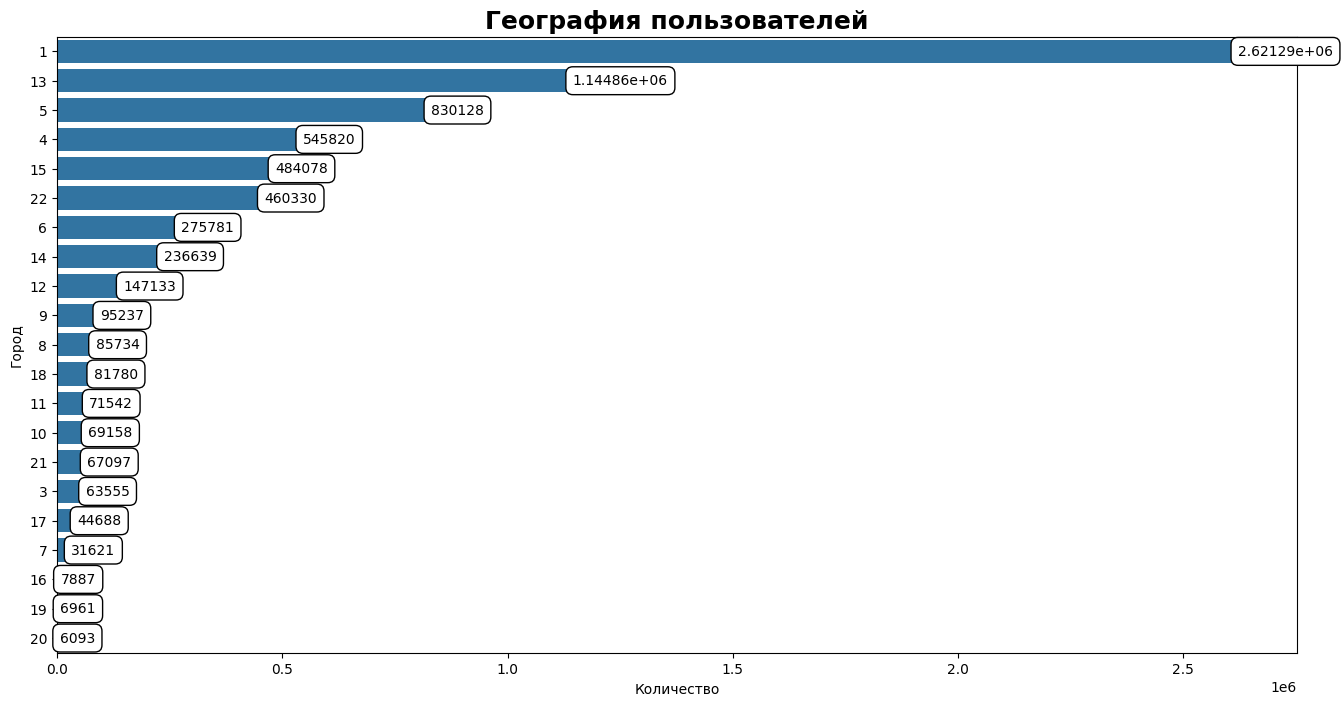

In [49]:
countplot = sns.countplot(data = df,
                          y = 'city',
                          order = city_counts.index)
countplot.bar_label(countplot.containers[0], bbox = bbox)

plt.title('География пользователей')
plt.xlabel('Количество')
plt.ylabel('Город')
plt.show()

- Больше всего пользователей проживают в городе, закодированном под номером 1
- В основном все распределение пользователей - это города 1 и 13 
- Меньше всего пользователей находятся в городах 16, 19 и 20

### Возрастное распределение пользователей
---
Рассматриваем только тех пользователей - у которых есть значения возраста (то есть значения не 0)

In [50]:
age_df = df[df['bd'] > 0]

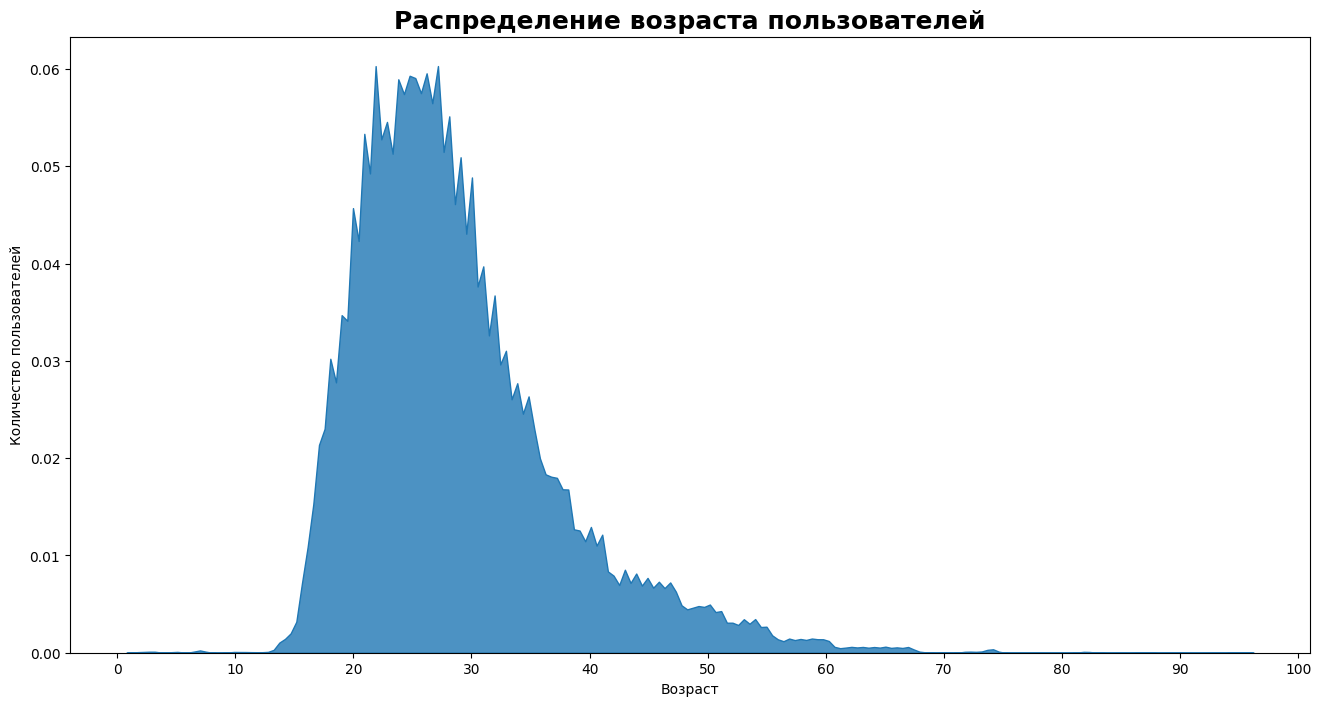

In [51]:
sns.kdeplot(data = age_df,
            x = 'bd',
            fill = True,
            alpha = 0.8)

plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(range(0, 101, 10))

plt.show()

- В основном на платформе мы имеет возраст от 13 до 40
- Так же есть значения возраста, которые лежат в диапазоне от 0 до 10 (то есть дети)
- А так же есть занчения возраста, которые больше 60 (пожилые)
- На краях распределения (дети и пожилые) значений немного (относительно основной группы возраста людей которая находится на платформе)

### Методы регистрации пользователей

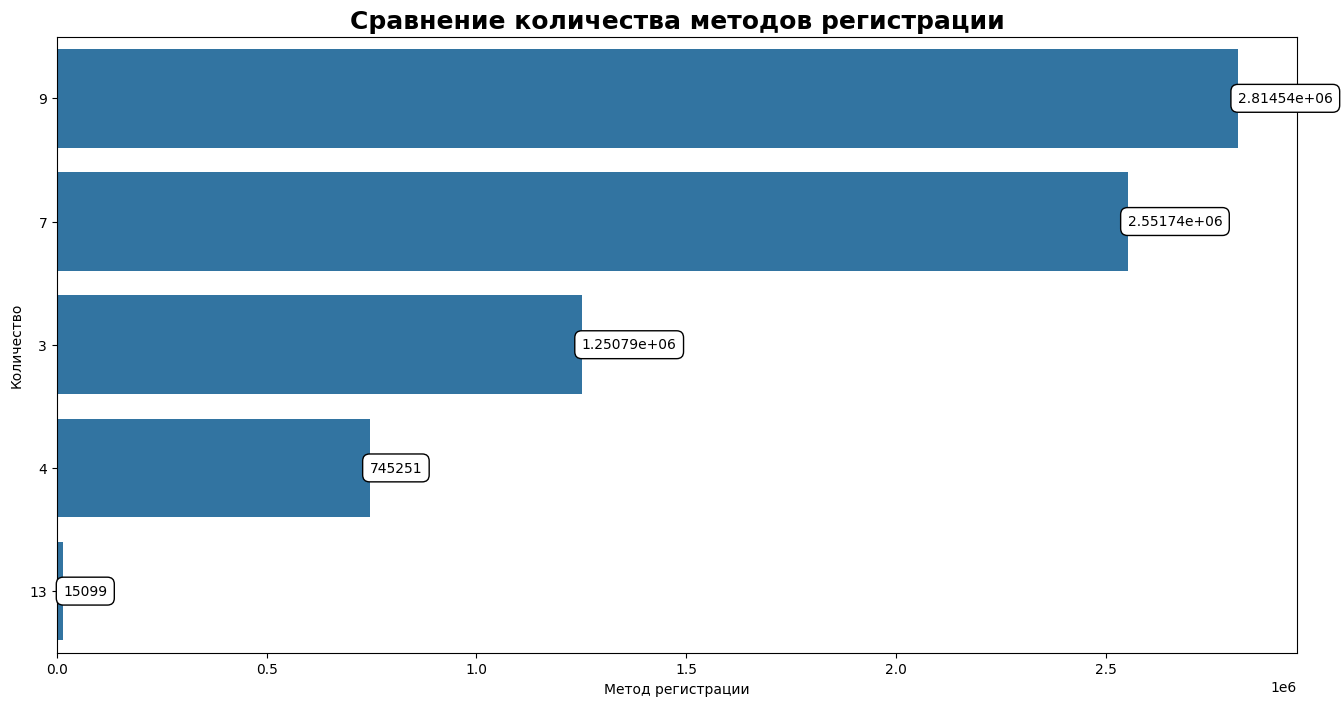

In [52]:
reg_via = df['registered_via'].value_counts()

countplot = sns.countplot(data = df,
              y = 'registered_via',
              order = reg_via.index)
countplot.bar_label(countplot.containers[0], bbox = bbox)

plt.title('Сравнение количества методов регистрации')
plt.xlabel('Метод регистрации')
plt.ylabel('Количество')

plt.show()

- Больше всего пользователей регистрируется с помощью метода 9
- На 9 и 7 метод регистрации приходится большинство зарегистрированных пользователей
- методом 13 почти никто не регистрируется - он является непопулярным

### Динамика регистраций пользователей на платформе

In [53]:
# Создаем таблицу в которой показывается динамика по годам, месяцам и дням - а также по зарегистрированным пользователям 
dynamics_mounth = df.groupby(['year_registration', 'month_registration', 'day_registration']).agg({'msno' : lambda x: len(set(x))})
dynamics_mounth.index.name = None
dynamics_mounth

msno
year_registration month_registration day_registration      
2004              3                  26                   2
                                     27                  10
                                     28                  13
                                     29                   4
                                     30                   7
...                                                     ...
2017              1                  27                  97
                                     28                  85
                                     29                  63
                                     30                  89
                                     31                  82

[3811 rows x 1 columns]

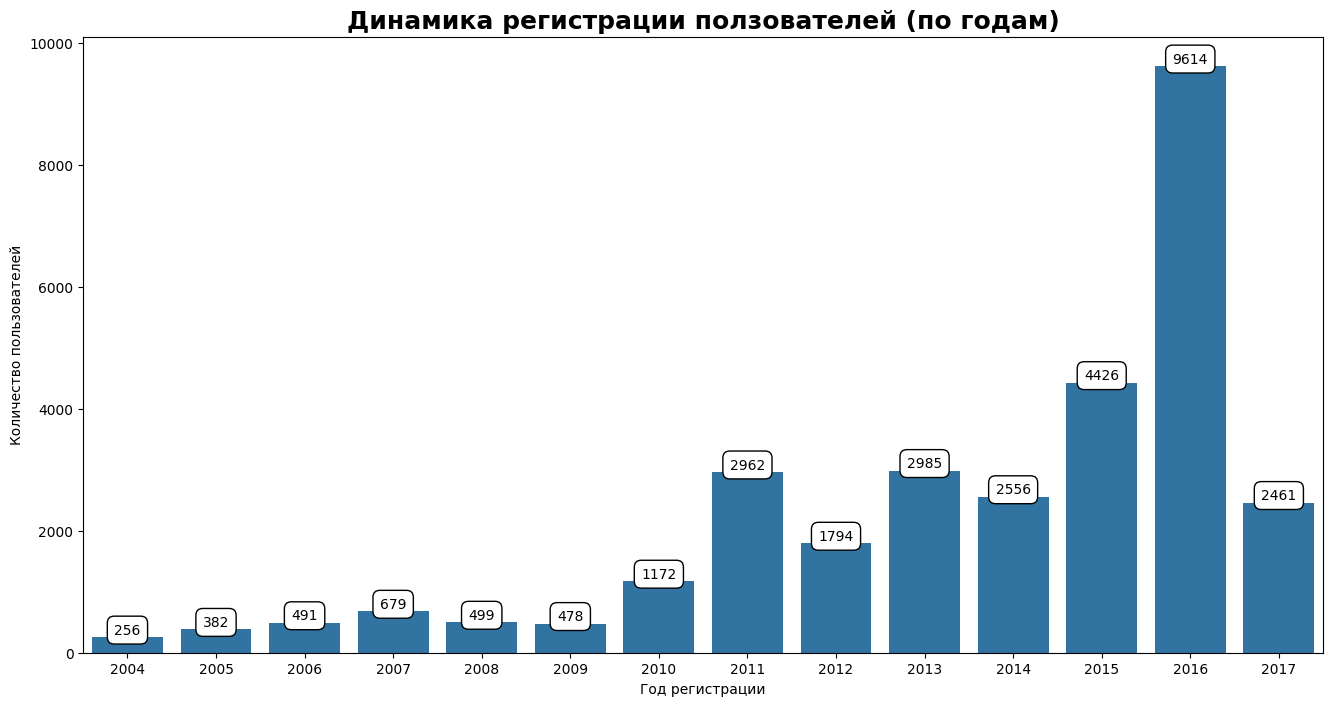

In [54]:
# Группировка для создания значений год - количество пользователей, которые пришли на платформу в этом году
group_year = dynamics_mounth.groupby('year_registration').agg({'msno': 'sum'})

# Визуализация
barplot = sns.barplot(data = group_year,
            x = group_year.index,
            y = 'msno')
barplot.bar_label(barplot.containers[0], bbox = bbox)

plt.title('Динамика регистрации ползователей (по годам)')
plt.xlabel('Год регистрации')
plt.ylabel('Количество пользователей')

plt.show()

- Больше всего пользователей зарегистрировалось на платформе в 2016 году
- в 2004 году меньше всего зарегистрированных пользователей - что может быть связано с недавней публикации сервиса (неизвестность)
- с 2010 года количество пользователей на платформе имеет возрастающую тенденцию

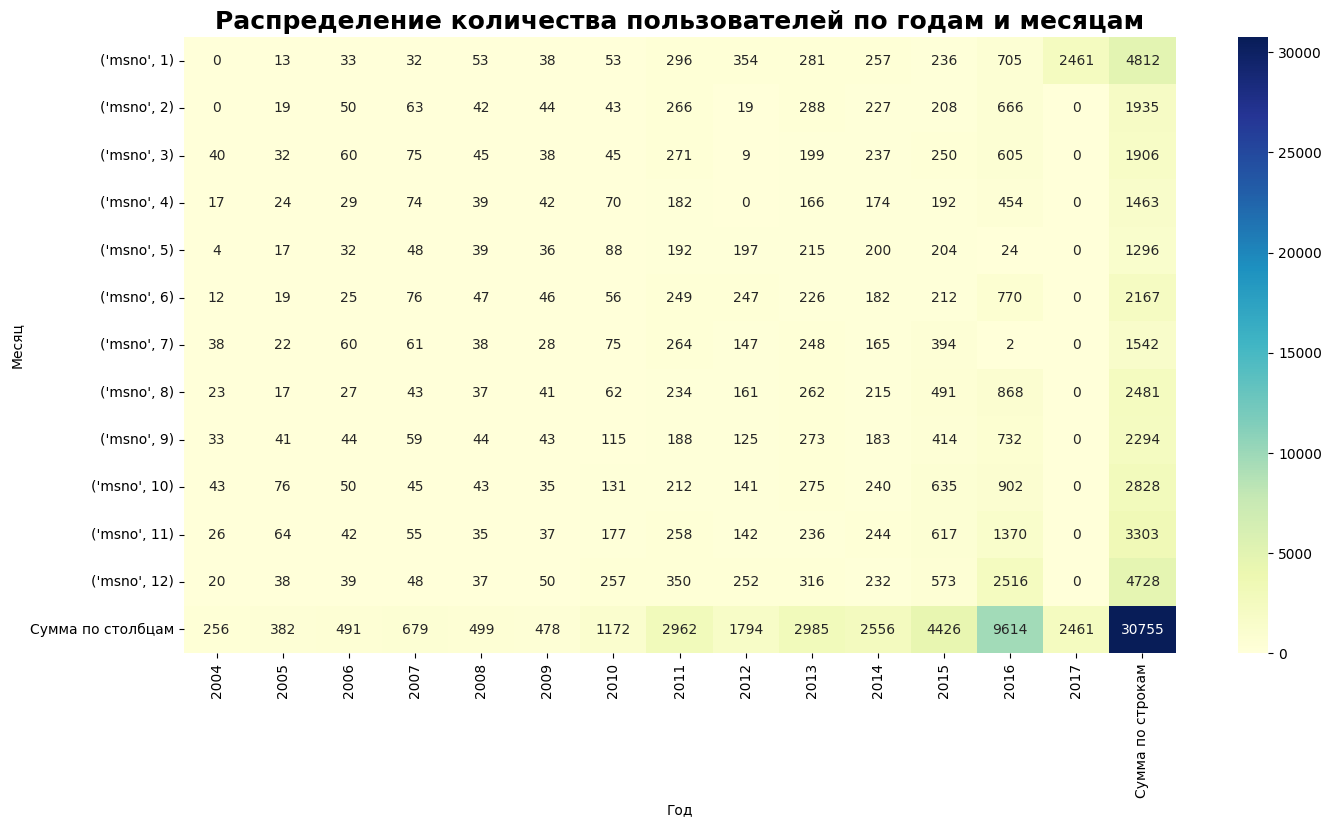

In [55]:
# Группировка по годам и меясцам 
group_mounth = dynamics_mounth.groupby(['year_registration', 'month_registration']).agg({'msno': 'sum'}).unstack().T
group_mounth = group_mounth.fillna(0)
group_mounth = group_mounth.astype('int')

# Сумма по строкам - для подсчета сколько зарегистрировалось за определенный месяц 
group_mounth['Сумма по строкам'] = group_mounth.sum(axis=1)

# Сумма по столбцам - для определения сколько пользователей зарегистрировались за определенный год
group_mounth.loc['Сумма по столбцам'] = group_mounth.sum()

# Визуализация матрицы для определения когда больше всего было зарегистрирвоано пользоватлей
sns.heatmap(group_mounth, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel('Месяц')
plt.xlabel('Год')
plt.title('Распределение количества пользователей по годам и месяцам')
plt.show()

In [56]:
# Создание таблицы для минимальных значений регистраций по каждому году и месяцу
min_value = group_mounth[group_mounth > 0].idxmin()[:-1].to_frame()
min_value = min_value.rename(columns={0: 'Месяц_min'})
# Оставляем только значение месяца
min_value['Месяц_min'] = min_value['Месяц_min'].apply(lambda x: x[1])
# Удаляем название индекса 
min_value.index.name = None
# Добавляем минимальные значения регистрации пользователя
min_value['Мин_рег_польз'] = group_mounth[group_mounth > 0].min().astype('int')[:-1]

min_value.groupby('Месяц_min').agg({'Месяц_min' : 'count'})

Месяц_min
Месяц_min           
1                  3
2                  1
3                  1
4                  3
5                  1
6                  1
7                  3
11                 1

In [57]:
# Создание таблицы для максимальных значений регистраций по каждому году и месяцу
max_values = group_mounth[group_mounth > 0].loc[:('msno', 12)].drop('Сумма по строкам', axis = 1).idxmax().to_frame()
max_values = max_values.rename(columns={0: 'Месяц_max'})
# Оставляем только значение месяца
max_values['Месяц_max'] = max_values['Месяц_max'].apply(lambda x: x[1])
# Удаляем название индекса 
max_values.index.name = None
# Добавляем минимальные значения регистрации пользователя
max_values['Макс_рег_польз'] = group_mounth[group_mounth > 0].loc[:('msno', 12)].drop('Сумма по строкам', axis = 1).max().astype('int')

# Группировка по количеству максимальных значений за каждый месяц
max_values.groupby('Месяц_max').agg({'Месяц_max' : 'count'})

Месяц_max
Месяц_max           
1                  4
3                  1
6                  1
10                 3
12                 5

In [58]:
pd.concat([min_value,max_values], axis = 1)

Месяц_min  Мин_рег_польз  Месяц_max  Макс_рег_польз
2004          5              4         10              43
2005          1             13         10              76
2006          6             25          3              60
2007          1             32          6              76
2008         11             35          1              53
2009          7             28         12              50
2010          2             43         12             257
2011          4            182         12             350
2012          3              9          1             354
2013          4            166         12             316
2014          7            165          1             257
2015          4            192         10             635
2016          7              2         12            2516
2017          1           2461          1            2461

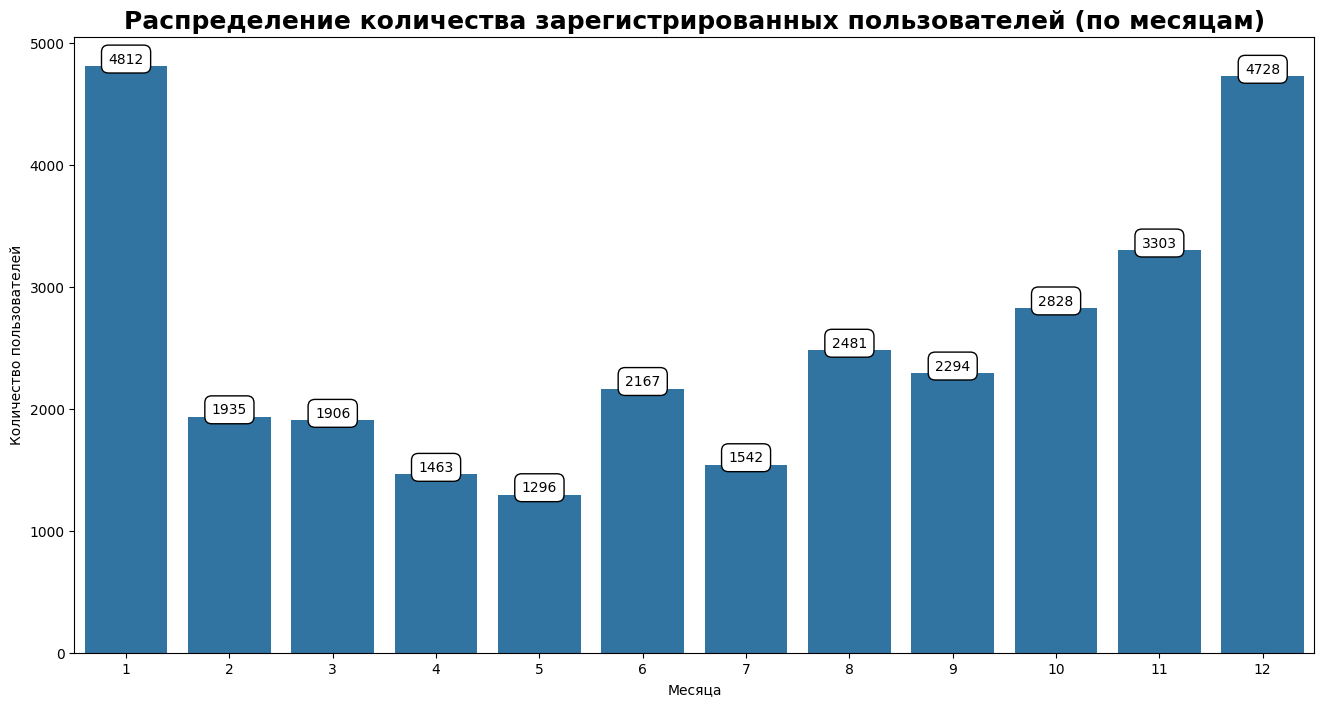

In [59]:
values_sum_mounth = group_mounth['Сумма по строкам'].values[:-1]
index = range(1,13)

barplot = sns.barplot(x = index,
                      y = values_sum_mounth)
barplot.bar_label(barplot.containers[0], bbox = bbox)

plt.title('Распределение количества зарегистрированных пользователей (по месяцам)')
plt.xlabel('Месяца')
plt.ylabel('Количество пользователей')

plt.show()

In [60]:
# Максимальное количество зарегистрированных пользователей в день
max_user_reg = dynamics_mounth['msno'].max()
# Значение индекса максимального дня 
max_user_reg_index = dynamics_mounth['msno'].idxmax()

print(f"""Больше всего пользователей за день зарегистрировалось:
        {max_user_reg_index[2]} числа, 
        {max_user_reg_index[1]} месяца, 
        {max_user_reg_index[0]} года. 
        Их число составило {max_user_reg}""")

Больше всего пользователей за день зарегистрировалось:
        3 числа, 
        12 месяца, 
        2016 года. 
        Их число составило 115


In [61]:
# Минимальное количество зарегистрированных пользователей в день
min_user_reg = dynamics_mounth['msno'].min()
# Индекс дня, когда было минимально количество регистраций
min_user_reg_index = dynamics_mounth['msno'].idxmin()

print(f"""Больше всего пользователей за день зарегистрировалось:
        {min_user_reg_index[2]} числа, 
        {min_user_reg_index[1]} месяца, 
        {min_user_reg_index[0]} года. 
        Их число составило {min_user_reg}""")

Больше всего пользователей за день зарегистрировалось:
        2 числа, 
        4 месяца, 
        2004 года. 
        Их число составило 1


- Начальные регистрации на платформе начались в марте 2004 года
- В первый месяц работы приложения зарегистрировались 40 пользователей
- В 2017 году имеем данные только за первый месяц года
- В 2017 году за 1 месяц зарегистрировалось 2461 пользователь
- В первые 6 лет с момента начала сбора даных- на платформе не было больше 100 регистраций за месяц
- Первый месяц, когда было больше 100 регистраций - сентябрь 2010 года
- После этой даты только 4 раза за всю следующую историю было зарегистрированно за месяц меньше 100 пользоавтелей (это были месяца март апрель 2012 года и май июль 2016 года)
- за май 2012 года не было данных (так как значения NaN заполнялись 0)
---
По таблице с минимальным значением регистраций за месяц
- Минимальное количество регистраций было в июле 2016 года
- Среди минимальных значений - максимальное значения минимальных пользователей (не считая 2017 год) - в апреде 2015 года
- Не считаем 2017 год - так как в нем всего одно значение - которое является макимальным, минимальным и суммой по году
- В основном - минимальное значение зарегистрированных пользователей приходися на январь, май и июнь
___
Максимальные значение регистраций по месяцам:
- Больше всего максимальных значений приходится на декабрь и январь года
- Список месяцев которые включают в себя максимальные значения - яндварь, март, июнь, октябрь и декабрь - то есть в каждом сезоне года присутствует максимальное количество зарегистрированных пользователей
- Максимальнле значение зарегистрированных пользователей приходится на декабрь 2016 года - 2516 пользователей
___
По графику распределение количества зарегистрированных пользователей по месяцам
- В основном пользователи регистрируются в январе и декабре
- К июню идет убывающая тенденция, а с июля уже начинается возрастающая тенденция
- Минимальное количество зарегистрированных пользователей за месяц приходится на май
- Максимальное число зарегистрированны - приходится на январь
___
- 3 декабря 2016 года - в этот день зарегистрировалось больше всего пользователей - 115
- 2 апреля 2004 года зарегистрировалось меньше всего пользователей - 1

### Длительность нахождения на платформе

In [62]:
df.columns

Index(['msno', 'city', 'bd', 'gender', 'registered_via', 'year_registration',
       'month_registration', 'day_registration', 'year_expiration',
       'month_expiration', 'day_expiration', 'song_id', 'name', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
       'source_system_tab', 'source_screen_name', 'source_type', 'target',
       'country_code', 'year_registration_track'],
      dtype='object')

In [63]:
df.head(2)

msno  city    bd   gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0  unknown   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   

   registered_via  year_registration  month_registration  day_registration  \
0               7               2012                   1                 2   
1               9               2011                   5                25   

   year_expiration  month_expiration  ...      artist_name  \
0             2017                10  ...         Bastille   
1             2017                 9  ...  Various Artists   

               composer lyricist  language source_system_tab  \
0  Dan Smith| Mark Crew  unknown      52.0           explore   
1               unknown  unknown      52.0        my library   

    source_screen_name      source_type target  country_code  \
0              Explore  online-playlist      1            GB   
1  Local playlist more   local-playlist      1            US   

  year_registration_track  
0                      16  
1                      99  

[2 rows x 25 columns]

In [64]:
# Создание таблицы для даты регистрации и даты удаления аккаунта 
data = pd.DataFrame()

#Из 3х столбцов преобразуем в один с типом данных datetime - дата регистрации 
data['Дата_регистрации'] = pd.to_datetime(df['year_registration']*10000\
                                             + df['month_registration']*100\
                                             + df['day_registration'],\
                                             format='%Y%m%d')
# Тоже самое - только дата удаления аккаунта 
data['Дата_удаления_аккаунта'] = pd.to_datetime(df['year_expiration']*10000\
                                                + df['month_expiration']*100\
                                                + df['day_expiration'],\
                                                format='%Y%m%d')

# Добавление разницы между днем регистрации и днем удаления аккаунта - это будет длительность нахождения на платформе
data['Длительность'] = (data['Дата_удаления_аккаунта'] - data['Дата_регистрации']).dt.days.astype(int)

data.head()

Дата_регистрации Дата_удаления_аккаунта  Длительность
0       2012-01-02             2017-10-05          2103
1       2011-05-25             2017-09-11          2301
2       2011-05-25             2017-09-11          2301
3       2011-05-25             2017-09-11          2301
4       2012-01-02             2017-10-05          2103

In [65]:
data[data['Длительность'] < 0]

Дата_регистрации Дата_удаления_аккаунта  Длительность
2487533       2014-05-01             1970-01-01        -16191
2487534       2014-05-01             1970-01-01        -16191
2487535       2014-05-01             1970-01-01        -16191

- В наборе данных есть значения - в которых длительность нахождения на платформе отрицаиельная - удалим такие значения (так как не может быть отрицательной длительности нахождения на платформе)
- 1970-01-01 - начальная точка отсчета времени (UNIX)

In [66]:
# Индексы в которых отрицаиельноые значения длительности
index = data[data['Длительность'] < 0].index
# Удаляем индексы, в которых отрицательные значения продолжительности (в основном наборе данных)
df = df.drop(index)
# Удалим отрицательные значения в таблице для исследования времени продолжительности нахождения на платформе
data = data.drop(index)

In [67]:
# Вставляем перед 11 индексом значение длительности нахождения на платформе в основной набор данных
df.insert(11, column = 'duration', value = data['Длительность'])

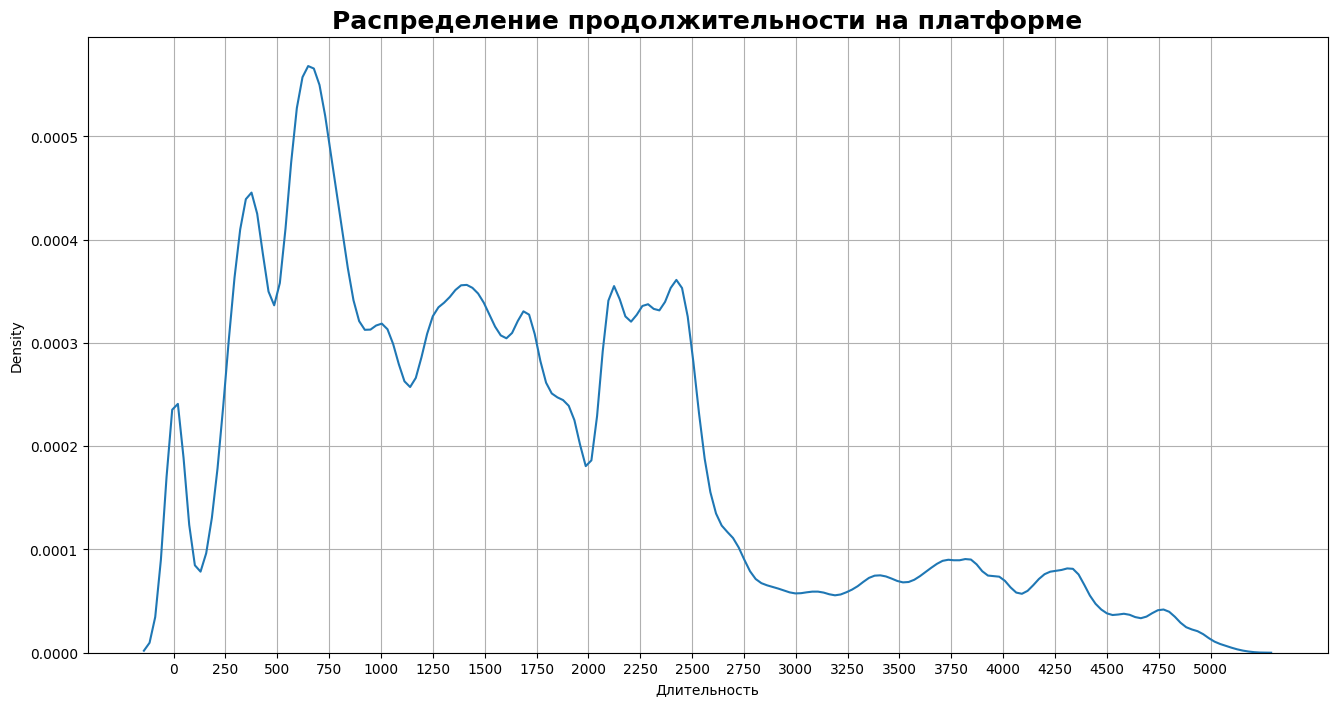

In [68]:
# Распределение длительности нахождения на платформе
sns.kdeplot(data = data,
             x = 'Длительность')

plt.title('Распределение продолжительности на платформе')
plt.xticks(range(0, 5101, 250))
plt.grid(True)
plt.show()

In [69]:
data['Длительность'].describe()

count    7.377415e+06
mean     1.627969e+03
std      1.128616e+03
min      0.000000e+00
25%      7.010000e+02
50%      1.433000e+03
75%      2.286000e+03
max      5.149000e+03
Name: Длительность, dtype: float64

- В среднем пользователи задерживаются на платформе - 1627 дня - это больше 4х лет
- Так же есть пользователи, которые не остались на платформе - то есть удалили свой аккаунт в тот же день, в который зарегистрировались
- Больше всего пользователей находится на платформе от 500 до 750 дней
- То есть вероятность того, что пользователь останется на платформе больше года - высокая
- Больше всего на платформе находился пользователь, который провел 5149 дней на платформе

### Распределение длительности песни

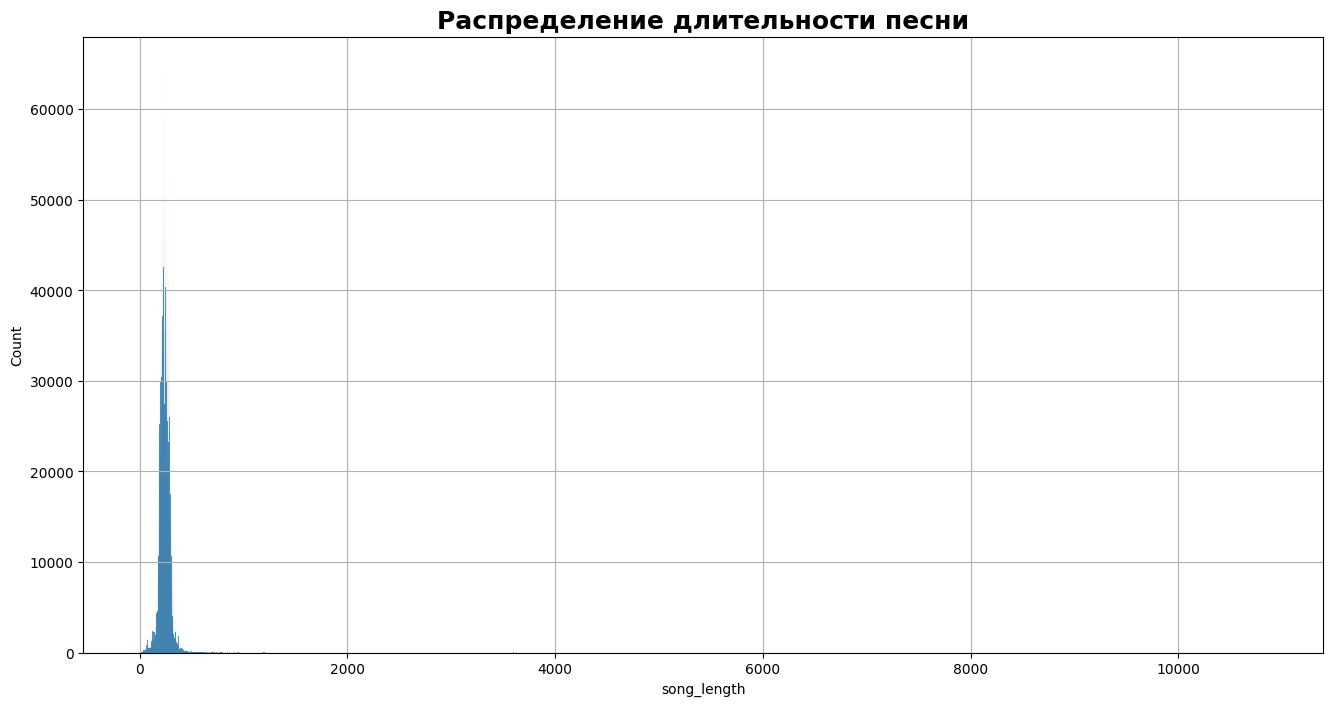

In [70]:
sns.histplot(data = df,
             x = 'song_length')

plt.title('Распределение длительности песни')
plt.grid(True)
plt.show()

In [71]:
# Выбираем только те треки, у которых есть продолжительность (так как мы заменяли пропуски значением 0)
df[df['song_length'] > 0]['song_length'].describe()

count    7.377301e+06
mean     2.451210e+02
std      6.734472e+01
min      1.393000e+00
25%      2.147260e+02
50%      2.418120e+02
75%      2.721600e+02
max      1.085171e+04
Name: song_length, dtype: float64

- Большинство длительности треков находится в диапазоне от 1 до 400 (в секундах)
- По графику распределения, и по описательной статистике видно - что в данном признаке есть выбросы
- Заменим выбросы (чтобы не терять данные и историю пользователей) с помощью IQR метода

In [72]:
# Находим 25 процентиль столбца song_length
q1 = df['song_length'].quantile(0.25)
# Находим 75 процентиль
q3 = df['song_length'].quantile(0.75)

# Считаем разницу между 3 и 1 значением
iqr = q3 - q1
# Нижняя граница 
lower_bound = q1 - 1.5 * iqr
# Верхняя граница 
upper_bound = q3 + 1.5 * iqr

# Значения которые надо заменить
indexes_to_replace = df[(df['song_length'] < lower_bound) | (df['song_length'] > upper_bound)].index
# Медианное значение 
median_value = df['song_length'].median()
# Замена выбросов на медианное значение
df.loc[indexes_to_replace, 'song_length'] = median_value

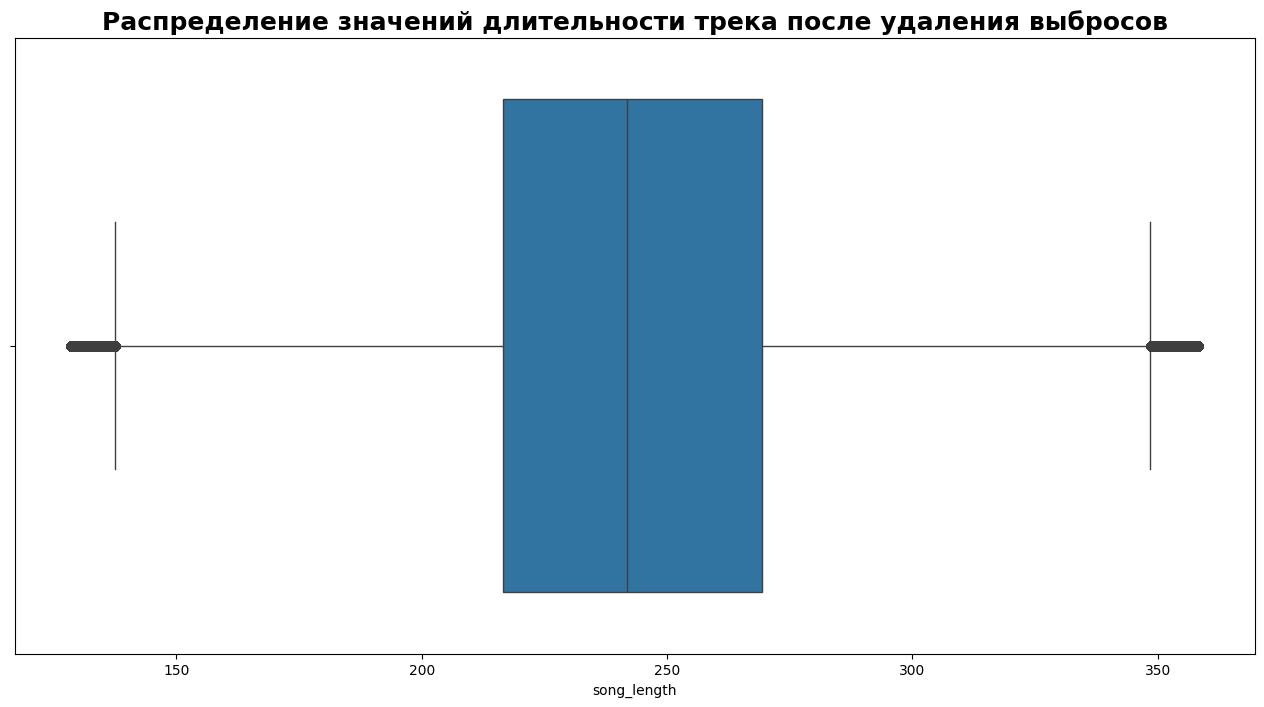

In [73]:
sns.boxplot(x = df['song_length'])

plt.title('Распределение значений длительности трека после удаления выбросов')
plt.show()

### Распределение языков

In [74]:
# Преобразование в тип данных int (чтобы измбавиться от лишних нулей)
df['language'] = df['language'].astype('int')

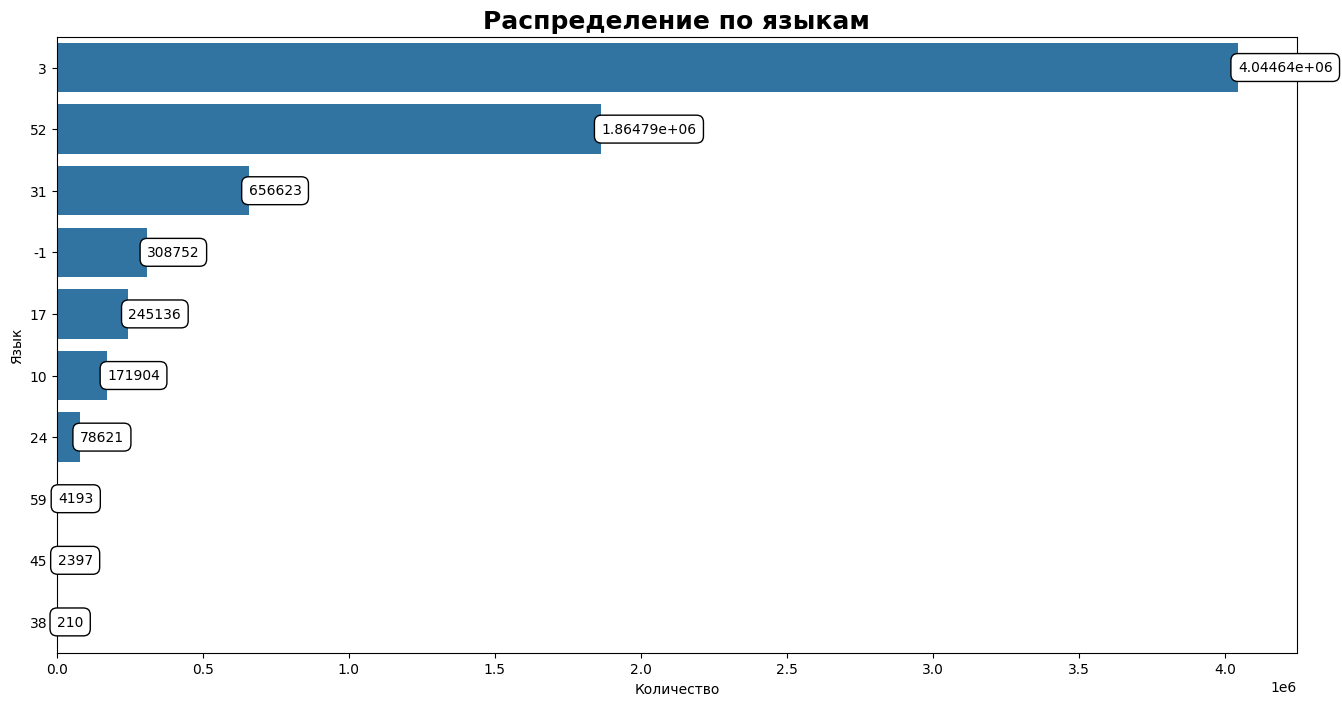

In [75]:
language = df[df['language'] != 0]['language'].value_counts().sort_values(ascending = False)

countplot = sns.countplot(data = df,
                          y = 'language',
                          order = language.index)
countplot.bar_label(countplot.containers[0], bbox = bbox)

plt.title('Распределение по языкам')
plt.xlabel('Количество')
plt.ylabel('Язык')

plt.show()

- Больше всего закодированно языка под значением 3
- Меньше всего значений по языку 38
- Большая часть треков приходится на языки 3 и 52

### Распределение регистрации треков

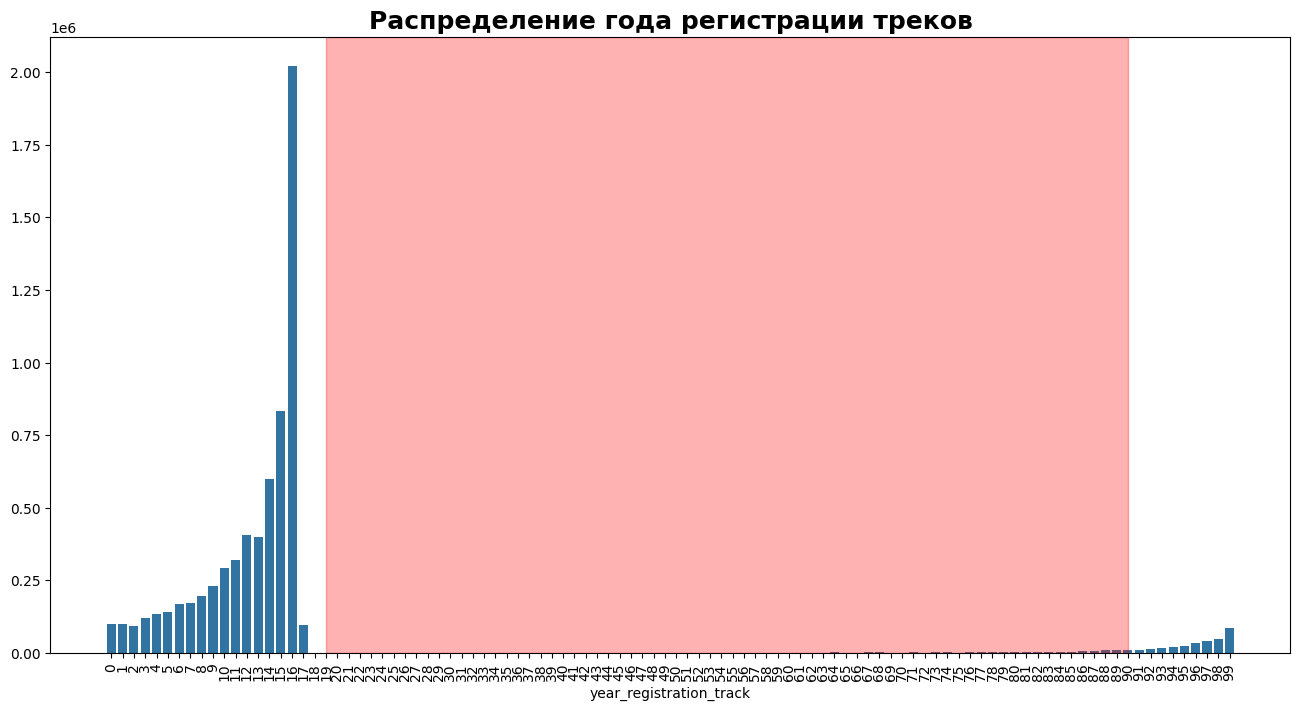

In [76]:
# Выбор значений которые непропущены (то есть не равны -1)
year_registration_track = df[df['year_registration_track'] != -1]['year_registration_track'].value_counts()

# Визуализация значений
sns.barplot(x = year_registration_track.index,
            y = year_registration_track.values)

plt.title('Распределение года регистрации треков')
# Выделяем область, которую отобразим на другом графике
plt.axvspan(19, 90, color='red', alpha=0.3)
# Поворот значений на оси x
plt.xticks(rotation=90)

plt.show()

Так как значения в красном диапазоне непонятны на данном графике (другой масштаб переменных) - отразим их отдельно

In [77]:
print(year_registration_track.idxmin())
print(year_registration_track.min())

43
2


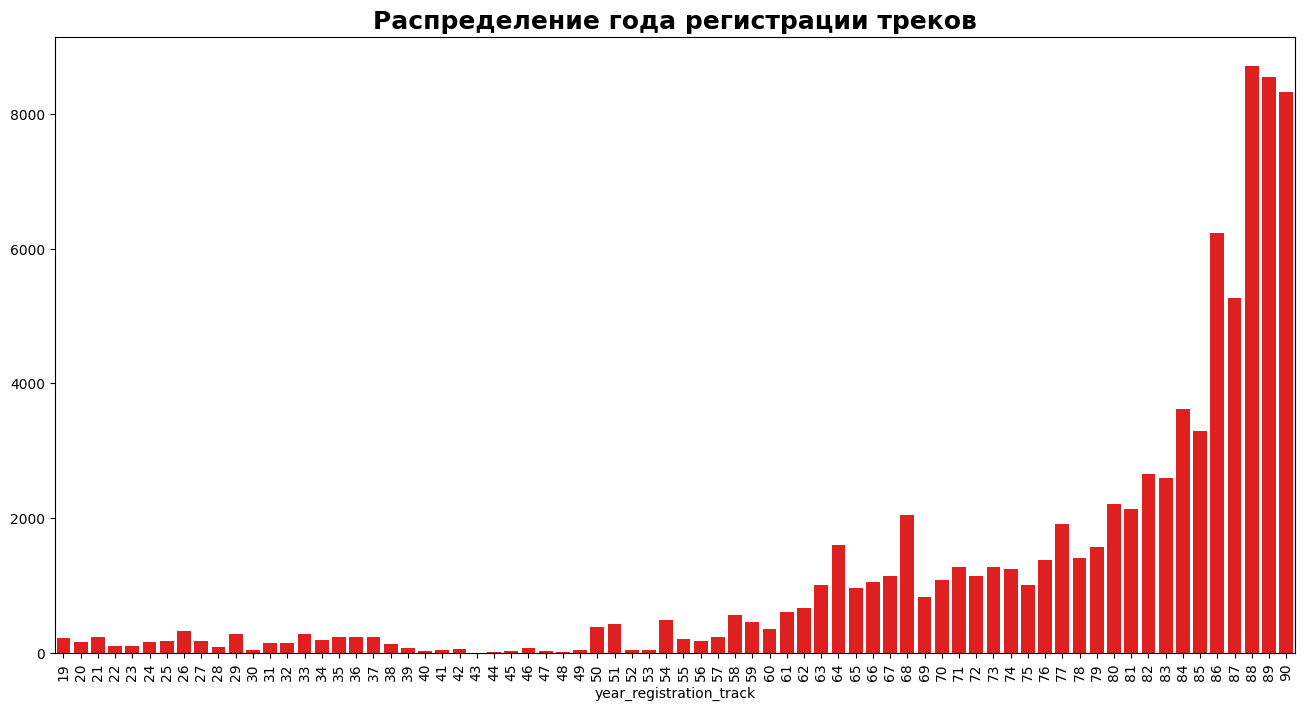

In [78]:
# Выбираем значения, которые входя в красный диапазон сверху на графике
year_registration_track_2 = df[(df['year_registration_track'] >= 19) & \
                               (df['year_registration_track'] <= 90)]\
                               ['year_registration_track']\
                               .value_counts()

# Визуализаци
sns.barplot(x = year_registration_track_2.index,
            y = year_registration_track_2.values,
            color = 'r')

plt.title('Распределение года регистрации треков')
plt.xticks(rotation=90)

plt.show()

- Больше всего треков было зарегистрировано в 2016 году
- Меньше всего треков было зарегистрировано в 1943 году - их количество составило 2 значения
- первый трек был выпущен в 1919 году (так как набор данных заканчивается на 2017 - следовательно 19 значение - это 1919 год)
- с 1960 года прослеживается возрастающая тенденция - то есть начинают все больше и больше выпускать треков
- Тенденция продолжается с 1960 года по 2017
- в 2017 году наблюдается спад - так как имеем данные только за январь 2017 года (1 месяц а не 12)

### Распределение по стране выпуска трека

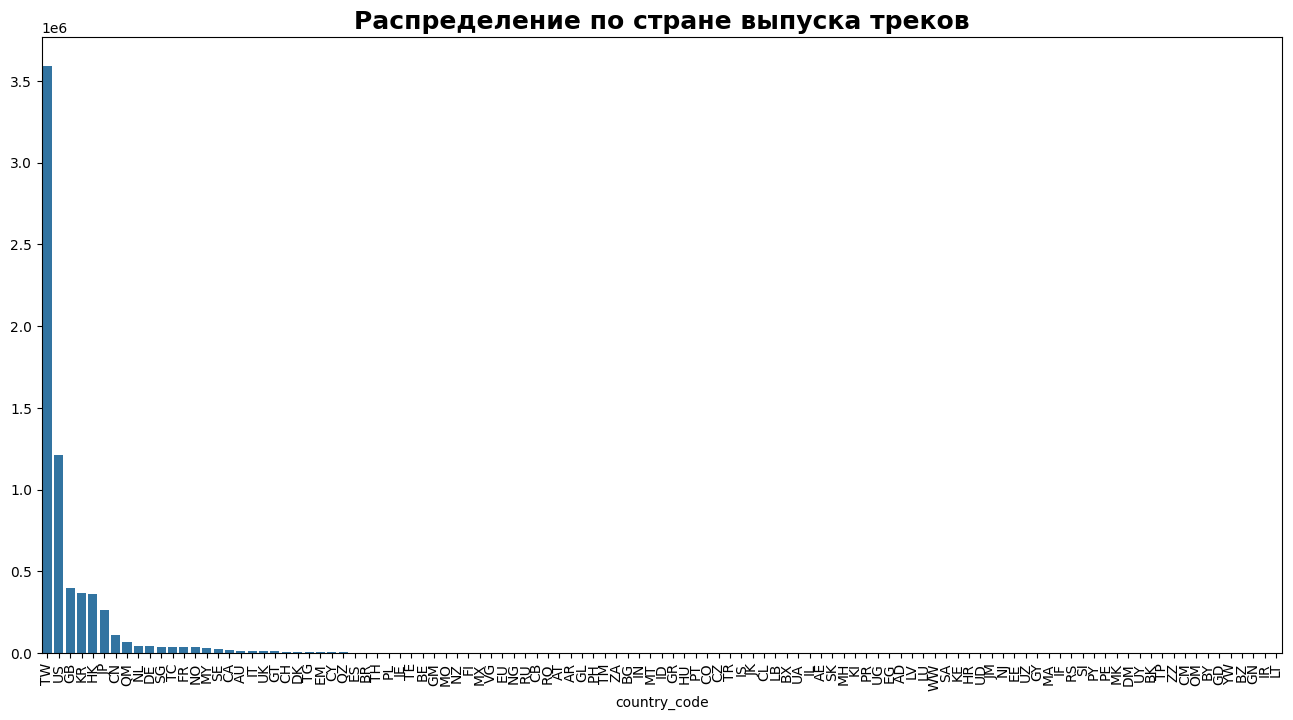

In [79]:
# Таблица страна выпуска - количество выпусков
country_code = df[df['country_code'] != 'unknown']['country_code'].value_counts().sort_values(ascending = False)

# Построение графика 
sns.barplot(x = country_code.index,
            y = country_code.values)
# Разворот оси
plt.xticks(rotation=90)
plt.title('Распределение по стране выпуска треков')

plt.show()

In [80]:
# Количество стран в коорых был выпущен всего 1 трек
country_code[country_code == 1].count()

13

- Больше всего треков было выпущено в TW - это значение равняется 3588920
- Меньше всего было выпущено в LT - 1 трек
- В 13 странах было выпущено всего по одному треку

### Какой жанр больше всего слушают?

In [81]:
genre = df[df['genre_ids'] != 'unknown']['genre_ids'].value_counts()
genre.head(10)

genre_ids
465     3717687
458     1261208
921      350311
1609     315089
444      243600
1259     181713
2022     152545
359      109513
2122      71859
139       65827
Name: count, dtype: int64

In [82]:
(genre.loc['465'] + genre.loc['458']) / genre.sum() * 100

68.58964645073124

In [83]:
genre[genre == 1].count()

79

- Самый популярный жанр среди всего набора данных - 465 жанр - на него приходится 3 717 687 треков
- 79 жанров имеют только 1 песню
- 68% треков имеют жанры 465 и 458

### Кто самый популярный исполнитель?

In [84]:
artist_name = df['artist_name'].value_counts()
artist_name.head(10)

artist_name
Various Artists     303616
周杰倫 (Jay Chou)      186776
五月天 (Mayday)        182088
林俊傑 (JJ Lin)        115325
田馥甄 (Hebe)          104946
aMEI (張惠妹)           82799
陳奕迅 (Eason Chan)     76035
玖壹壹                  70445
G.E.M.鄧紫棋            67296
BIGBANG              61927
Name: count, dtype: int64

In [85]:
artist_name[artist_name == 1].count()

13201

- Среди всех исполнителей - самый популярный  Various Artists - его прослушали 303 616 раз
- 13 201 исполнитель имеют только 1 песню в наборе данных

### Какой трек самый популярный?

In [86]:
df['name'].nunique()

234144

In [87]:
name = df['name'].value_counts()
name.head(10)

name
演員                              19260
Closer                          15149
Faded                           15083
帥到分手                            13973
告白氣球                            13882
你，好不好？ (How Have You Been?)     13189
小幸運 (A little happiness)        13079
Alone                           12916
謝謝妳愛我 (Thanks For Your Love)    12004
讓我留在你身邊                         11835
Name: count, dtype: int64

In [88]:
# Количество треков, которые послушали только 1 раз
name[name == 1].count()

95629

In [89]:
# Количество треков которые послушали больше 1000 раз
name[name > 1000].count()

1267

- Всего уникальных треков - 234 144
- 演員 - этот трек послушали больше всего раз
- Количество его прослушиваний = 19 260
- 95 629 треков послушали только 1 раз
- больше 1000 раз послушали только 1267 треков

### Какие треки больше всего нравятся пользователям

In [90]:
# Группировка по количеству прослушиваний и количеству лайков 
song_id = df.groupby('name').agg({'target' : ['count', 'sum']})['target']
song_id.index.name = None
# Переименовывание столбцов 
song_id.columns = ['Количество прослушиваний', 'Количество лайков']
# Создание нового столбца - для отображения процента релевантности
song_id['%'] = (song_id['Количество лайков'] / song_id['Количество прослушиваний']) * 100
# Рассматриваем только те треки - которые послушали больше 100 раз
song_id = song_id[song_id['Количество прослушиваний'] > 100]
# Сортировка по проценту релевантности
song_id = song_id.sort_values(by = '%' , ascending = False)

# Вывод топ 10 релевантных треков
song_id.head(10)

Количество прослушиваний  \
妮妮 (Nini)                                                               2752   
Jumpshot                                                                 120   
In My Foreign (feat. Ty Dolla $ign| Lil Yachty|...                       118   
有可能的夜晚                                                                   188   
把愛收好 (Keep love)                                                         138   
Wait for You                                                             108   
Scared to Be Lonely                                                     1006   
告白氣球                                                                   13882   
帥到分手                                                                   13973   
紅顏舊 (Time Flies)                                                         106   

                                                    Количество лайков  \
妮妮 (Nini)                                                        2342   
Jumpshot                                                           99   
In My Foreign (feat. Ty Dolla $ign| Lil Yachty|...                 95   
有可能的夜晚                                                            149   
把愛收好 (Keep love)                                                  109   
Wait for You                                                       85   
Scared to Be Lonely                                               789   
告白氣球                                                            10858   
帥到分手                                                            10885   
紅顏舊 (Time Flies)                                                   82   

                                                            %  
妮妮 (Nini)                                           85.101744  
Jumpshot                                            82.500000  
In My Foreign (feat. Ty Dolla $ign| Lil Yachty|...  80.508475  
有可能的夜晚                                              79.255319  
把愛收好 (Keep love)                                    78.985507  
Wait for You                                        78.703704  
Scared to Be Lonely                                 78.429423  
告白氣球                                                78.216395  
帥到分手                                                77.900236  
紅顏舊 (Time Flies)                                    77.358491

In [91]:
song_id.tail()

Количество прослушиваний  \
Merry Christmas| Mr Lawrence (Instrumental)                       113   
Comancheria                                                       209   
Louder Than Bombs                                                 264   
Glider                                                            112   
Rogue One                                                         146   

                                             Количество лайков          %  
Merry Christmas| Mr Lawrence (Instrumental)                 16  14.159292  
Comancheria                                                 27  12.918660  
Louder Than Bombs                                           31  11.742424  
Glider                                                      13  11.607143  
Rogue One                                                   13   8.904110

- 妮妮 (Nini) из 2752 прослушиваний трек понравился 2342 пользователям - то есть его релевантность составила 85%
- Rogue One - релевантен меньше всего - он нравится всего 8% пользователей

### Кто больше всего слушает музыку?

In [92]:
# Объединяем и считаем сколько всего прослушиваний у пользователя и сколько он лайкает треков
msno_song_count = df.groupby('msno').agg({'target' : ['count', 'sum']})['target']
# Удаление названия индекса 
msno_song_count.index.name = None
# Выбор только тех пользователей - которые послушали больше 20 треков
msno_song_count = msno_song_count[msno_song_count['count'] > 20]
# Изменение название столбцов
msno_song_count.columns = ['Количество прослушиваний', 'Количество понравившихся']
# Создание нового столбца - % релевантных пользователю треков
msno_song_count['%'] = (msno_song_count['Количество понравившихся'] / msno_song_count['Количество прослушиваний']) * 100

msno_song_count.head()

Количество прослушиваний  \
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=                       589   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=                       220   
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=                       108   
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=                       222   
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=                       199   

                                              Количество понравившихся  \
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=                       293   
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=                       141   
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=                        76   
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=                        82   
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=                        96   

                                                      %  
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=  49.745331  
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=  64.090909  
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=  70.370370  
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=  36.936937  
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=  48.241206

In [93]:
# Количество пользователей, которые послушали на платформе больше 20 треков
len(msno_song_count)

24134

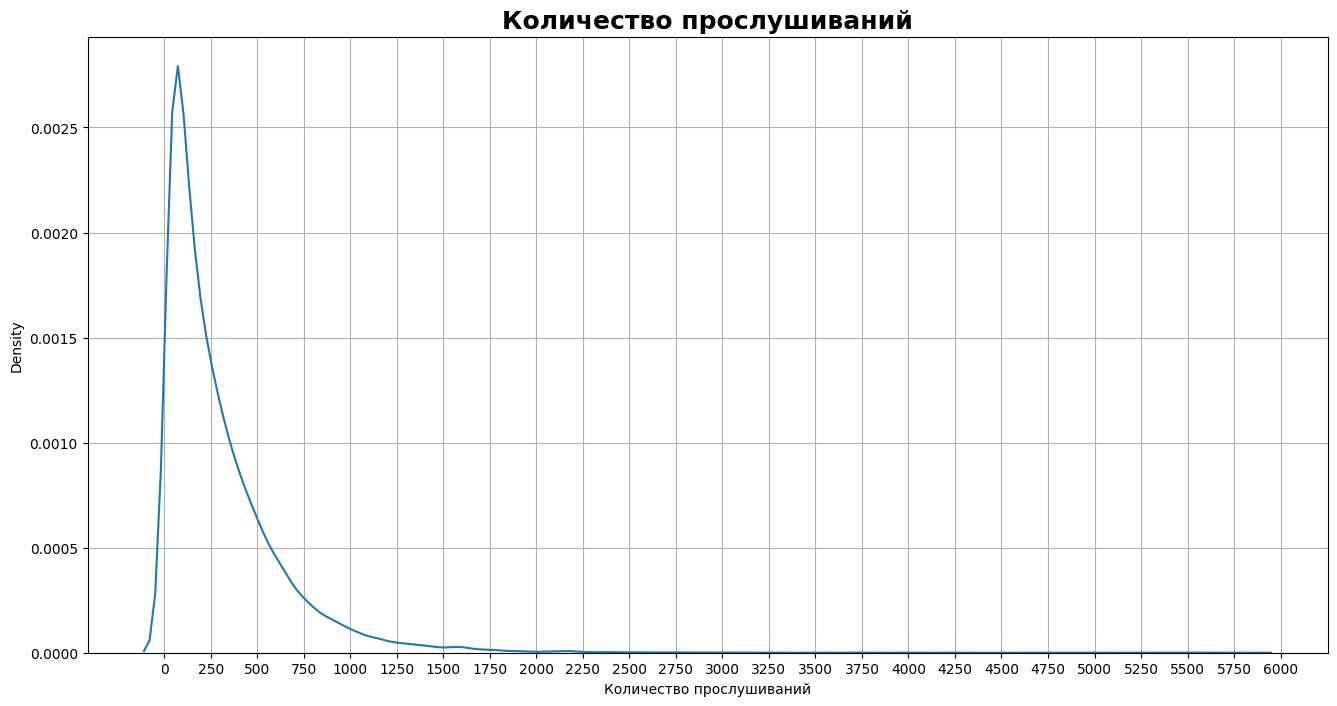

In [94]:
sns.kdeplot(msno_song_count['Количество прослушиваний'])
plt.title('Количество прослушиваний')
plt.xticks(range(0,6001, 250))
plt.grid(True)
plt.show()

In [95]:
msno_song_count['Количество прослушиваний'].max()

5819

In [96]:
msno_song_count.sort_values(by = '%', ascending = False).head(10)

Количество прослушиваний  \
m/Z7aOvHLe9e0BrsAVy5wYyJDY5Rrhnxq9FdtJ7ZfSM=                       119   
+riP79XvdQk1z7v7Ixi6YBxNLfZ6GYjg/nmPuk2LnRM=                        24   
E8tKFlbWSriXzy8HmcAWLMCqh687Gh34df+02YKpFJc=                       105   
9FmMeiJzk09fssi9oGc7NRRw/He64T9tETLkaV3GJgI=                        29   
CSpZYn64OYBHPQj/CI+Y8LtbfMtxMabPNdw/Jo9eqE8=                        25   
ZimDn7wlhPQj2kc2pe3OiQRnxnhvZqtQR7F3yNcyDok=                        32   
Y4uO/jTQDwjrqLBRrwt2ioptVKt3xQl2dnW9710V5Fg=                        85   
RUanpyN0ZhH1lXX9hEyfvyIm3TDFQhD4IWuvbW7HOJg=                       170   
gLB4jDCRSPSziD6myKnXVOBws0XRLMZdJJsX5aIqufA=                       319   
kED0uRnmECVD18+Nplx99zoF6BiVGOpZPZYLLjdKi94=                       113   

                                              Количество понравившихся      %  
m/Z7aOvHLe9e0BrsAVy5wYyJDY5Rrhnxq9FdtJ7ZfSM=                       119  100.0  
+riP79XvdQk1z7v7Ixi6YBxNLfZ6GYjg/nmPuk2LnRM=                        24  100.0  
E8tKFlbWSriXzy8HmcAWLMCqh687Gh34df+02YKpFJc=                       105  100.0  
9FmMeiJzk09fssi9oGc7NRRw/He64T9tETLkaV3GJgI=                        29  100.0  
CSpZYn64OYBHPQj/CI+Y8LtbfMtxMabPNdw/Jo9eqE8=                        25  100.0  
ZimDn7wlhPQj2kc2pe3OiQRnxnhvZqtQR7F3yNcyDok=                        32  100.0  
Y4uO/jTQDwjrqLBRrwt2ioptVKt3xQl2dnW9710V5Fg=                        85  100.0  
RUanpyN0ZhH1lXX9hEyfvyIm3TDFQhD4IWuvbW7HOJg=                       170  100.0  
gLB4jDCRSPSziD6myKnXVOBws0XRLMZdJJsX5aIqufA=                       319  100.0  
kED0uRnmECVD18+Nplx99zoF6BiVGOpZPZYLLjdKi94=                       113  100.0

In [97]:
msno_song_count.sort_values(by = '%', ascending = False).tail(10)

Количество прослушиваний  \
4lw3CqUHkBZs2Jy2Ki2DlWM2tMzDb5NB26lRpgQj2W4=                        29   
iW3PeK1L87VljKaDnDYA81I2jD1liYrQsmTX4auZOsQ=                        59   
z+2aIPX0bEZLcyxYsoDyKDPWl1zBfcjpKiHU6bLCrP4=                       145   
Yz8ikRfvnd0CPH65gH8GKQWRwwNMDJgvDVTUEm9NsQc=                        35   
s2UNNdJrqCiETKwNKrVu4Skto9CsZzGdBcasJDPubeI=                        21   
HW5dpa3PobRzMNd3vLH0wngHd9oovaSderlhztJJuss=                        52   
Dt/E7fBLWjJY5kMbr+qlsyDB1AoToreYwdzSCiIvwoA=                        26   
DuVqTeiJUbBq0mhcm4CWCSO4zydX+wlLc+tzDsIvZaU=                        25   
Dup4xnrIXJ/cQ9O36ItWthow327sfUpugdFMlWYwORk=                        71   
Bbcr2TgEfha5murZanXL0+BktXgZFV2/6KDC23BAXRs=                        37   

                                              Количество понравившихся    %  
4lw3CqUHkBZs2Jy2Ki2DlWM2tMzDb5NB26lRpgQj2W4=                         0  0.0  
iW3PeK1L87VljKaDnDYA81I2jD1liYrQsmTX4auZOsQ=                         0  0.0  
z+2aIPX0bEZLcyxYsoDyKDPWl1zBfcjpKiHU6bLCrP4=                         0  0.0  
Yz8ikRfvnd0CPH65gH8GKQWRwwNMDJgvDVTUEm9NsQc=                         0  0.0  
s2UNNdJrqCiETKwNKrVu4Skto9CsZzGdBcasJDPubeI=                         0  0.0  
HW5dpa3PobRzMNd3vLH0wngHd9oovaSderlhztJJuss=                         0  0.0  
Dt/E7fBLWjJY5kMbr+qlsyDB1AoToreYwdzSCiIvwoA=                         0  0.0  
DuVqTeiJUbBq0mhcm4CWCSO4zydX+wlLc+tzDsIvZaU=                         0  0.0  
Dup4xnrIXJ/cQ9O36ItWthow327sfUpugdFMlWYwORk=                         0  0.0  
Bbcr2TgEfha5murZanXL0+BktXgZFV2/6KDC23BAXRs=                         0  0.0

- Всего пользователей, которые послушали больше 20 треков на платформе - 24 134 из 30 754
- В основном ползователи слушают от 100 до 750 треков
- Больше всего прослушиваний - 5819
- Среди пользователей есть те - которым нравятся все треки, которые они прослушиали - то есть процент понравившихся треков составляет 100%
- Также есть пользователи - которым не понравился ни один трек - то есть процент понравившихся равен 0

In [11]:
df = processing(df)

In [12]:
df.head(2)

msno  city    bd   gender  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0  unknown   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0   female   

   registered_via  year_registration  month_registration  day_registration  \
0               7               2012                   1                 2   
1               9               2011                   5                25   

   year_expiration  month_expiration  ...  lyricist_count  language  \
0             2017                10  ...         3178814      52.0   
1             2017                 9  ...         3178814      52.0   

   source_system_tab   source_screen_name      source_type country_code  \
0            explore              Explore  online-playlist           GB   
1         my library  Local playlist more   local-playlist           US   

   year_registration_track percent_liked  number_auditions  target  
0                       16     45.733788               293       1  
1                       99    100.000000                 1       1  

[2 rows x 30 columns]

## Добавление новых признаков

### Процент песен, которые нравится пользователю
___
Признак означает следующее - насколько определенному пользователю нравятся треки 
- То есть процент понравившихся треков среди всех прослушанных треков определенным пользователем

In [136]:
# Добавление значения процент песен, который нравится пользователю
# Объединяем и считаем сколько всего прослушиваний у пользователя и сколько он лайкает треков
msno_song_count = df.groupby('msno').agg({'target' : ['count', 'sum']})['target']
# Удаление названия индекса 
msno_song_count.index.name = None
msno_song_count['%'] = (msno_song_count['sum'] / msno_song_count['count']) * 100

# Создание столбца - процент лайков пользователем
df['percent_liked_msno'] = df['msno'].map(msno_song_count['%'])

# Создание столбца - Количество прослушанных треков пользователем
df['count_tracks_listened_user'] = df['msno'].map(msno_song_count['count'])

### Насколько нравится песня (в процентах)
___
Данный признак обозначет следующее - насколько релевантна песня среди всего набора данных
- То есть если песня понравилась 80% пользователей со всего набора данных - то это и будет значение строки

In [133]:
# Добавление нового столбца - насколько нравится песня (в процентах)
# Группировка по количеству прослушиваний и количеству лайков 
song_id = df.groupby('name').agg({'target' : ['count', 'sum']})['target']
song_id.index.name = None
# Создание нового столбца - для отображения процента релевантности
song_id['%'] = (song_id['sum'] / song_id['count']) * 100

# Создание столбца - процент лайков
df['percent_liked'] = df['name'].map(song_id['%'])

# Создание столбца - количество раз сколько прослушали определенный трек
df['number_auditions'] = df['name'].map(song_id['count'])

### Количество прослушиваний определенного автора

In [294]:
artist_name_count = df.groupby('artist_name').agg({'target' : 'count'})
# Добавление нового признака
df['artist_name_count'] = df['artist_name'].map(artist_name_count['target'])

### Количество прослушиваний composer

In [297]:
composer_count = df.groupby('composer').agg({'target' : 'count'})
# Добавление нового признака
df['composer_count'] = df['composer'].map(composer_count['target'])

### Количество прослушиваний lyricist

In [299]:
lyricist_count = df.groupby('lyricist').agg({'target' : 'count'})
# Добавление нового признака
df['lyricist_count'] = df['lyricist'].map(lyricist_count['target'])

In [302]:
df.drop(['artist_name', 'composer', 'lyricist'], axis = 1, inplace = True)

## Кодирование категориальных переменных

In [13]:
# Удаление признаков msno, song_id, name
df.drop('name', axis = 1, inplace = True)

In [14]:
df.index = range(0,len(df))

### Кодирование с помощтю OneHot

In [15]:
# столбцы для кодирования
ohe_columns = ['gender', 'source_system_tab']

# Создание и кодирование OneHot
ohe = OneHotEncoder(sparse=False)
# кодирование столбцов
ohe_data = ohe.fit_transform(df[ohe_columns])
ohe_data = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

df = pd.concat([df,ohe_data], axis = 1)

In [16]:
# Удаляем значения, которые преобразованы с помощью OHE
df.drop(['gender', 'source_system_tab'], axis = 1, inplace = True)

In [17]:
# Сохранение OHE для кодирования
joblib.dump(ohe, 'OHEncodeer.pkl')

['OHEncodeer.pkl']

### Кодирование с помощью LabelEncoder

In [18]:
genre_ids_encoder = LabelEncoder()
source_screen_name_encoder = LabelEncoder()
source_type_encoder = LabelEncoder()
country_code_encoder = LabelEncoder()

In [19]:
df['genre_ids'] = genre_ids_encoder.fit_transform(df['genre_ids'])
df['source_screen_name'] = source_screen_name_encoder.fit_transform(df['source_screen_name'])
df['source_type'] = source_type_encoder.fit_transform(df['source_type'])
df['country_code'] = country_code_encoder.fit_transform(df['country_code'])

In [20]:
joblib.dump(genre_ids_encoder, 'genre_ids_encoder.pkl')

['genre_ids_encoder.pkl']

In [21]:
joblib.dump(source_screen_name_encoder, 'source_screen_name_encoder.pkl')

['source_screen_name_encoder.pkl']

In [22]:
joblib.dump(source_type_encoder, 'source_type_encoder.pkl')

['source_type_encoder.pkl']

In [23]:
joblib.dump(country_code_encoder, 'country_code_encoder.pkl')

['country_code_encoder.pkl']

In [24]:
df.dtypes

msno                               object
city                                int64
bd                                float64
registered_via                      int64
year_registration                   int32
month_registration                  int32
day_registration                    int32
year_expiration                     int32
month_expiration                    int32
day_expiration                      int32
duration                            int64
percent_liked_msno                float64
count_tracks_listened_user          int64
song_id                            object
song_length                       float64
genre_ids                           int64
artist_name_count                   int64
composer_count                      int64
lyricist_count                      int64
language                          float64
source_screen_name                  int64
source_type                         int64
country_code                        int64
year_registration_track           

In [25]:
df.head(2)

msno  city    bd  registered_via  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=     1   0.0               7   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=    13  24.0               9   

   year_registration  month_registration  day_registration  year_expiration  \
0               2012                   1                 2             2017   
1               2011                   5                25             2017   

   month_expiration  day_expiration  ...  gender_unknown  \
0                10               5  ...             1.0   
1                 9              11  ...             0.0   

   source_system_tab_discover  source_system_tab_explore  \
0                         0.0                        1.0   
1                         0.0                        0.0   

  source_system_tab_listen with  source_system_tab_my library  \
0                           0.0                           0.0   
1                           0.0                           1.0   

   source_system_tab_notification  source_system_tab_radio  \
0                             0.0                      0.0   
1                             0.0                      0.0   

   source_system_tab_search  source_system_tab_settings  \
0                       0.0                         0.0   
1                       0.0                         0.0   

   source_system_tab_unknown  
0                        0.0  
1                        0.0  

[2 rows x 39 columns]

### Матрица корреляции

In [46]:
corr = df.select_dtypes(exclude = ['object']).corr()

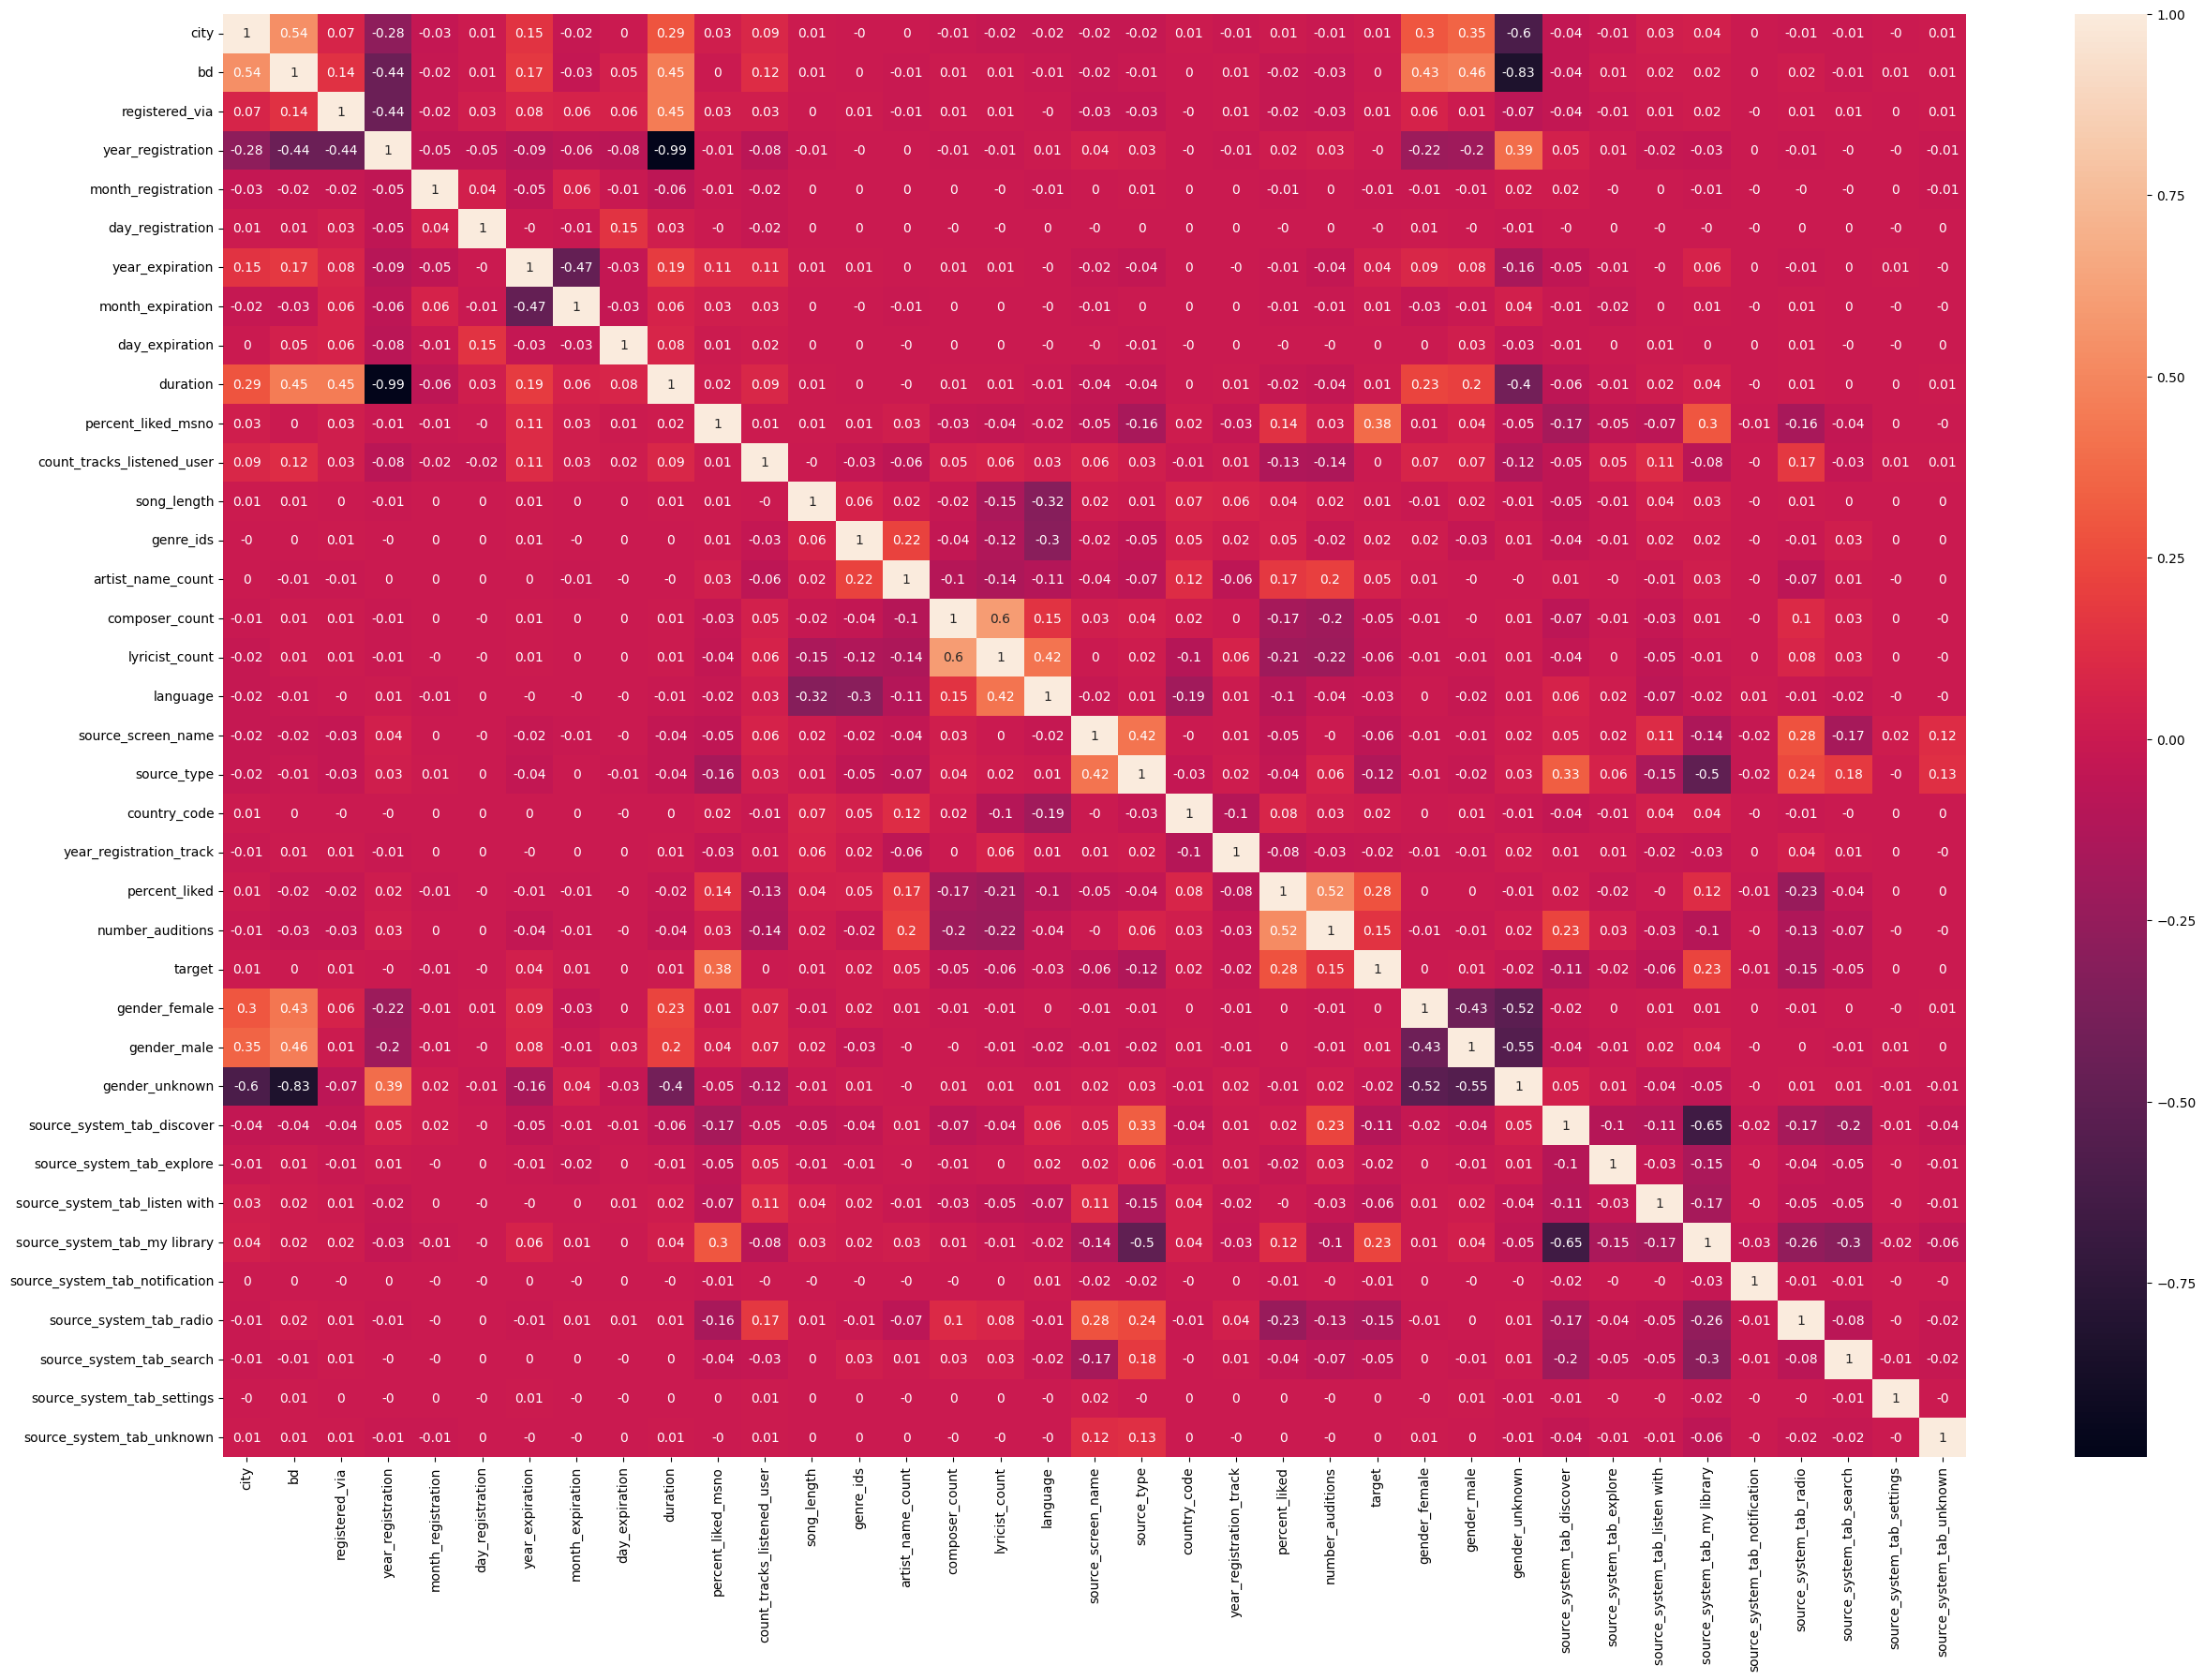

In [52]:
plt.figure(figsize=(30, 20))
sns.heatmap(round(corr,2), annot = True)
plt.show()

Мультиколлинеарность у следующийх столбцов 
- duration и year_registration
- gender_unknown и bd
- composer_count и lyricist_count
- source_system_tab_my_library и source_system_tab_discover

Удалим признаки и разделим набор данных на тестовый и тренировочный

In [26]:
df.drop(['gender_unknown', 'year_registration', 'lyricist_count', 'source_system_tab_discover'], axis = 1, inplace = True)

## Разделение набора данных на тестовый и тренировочный

___
Так как стоит задача сделать рекомендательную систему - и оценить модель с помощью метрики NDCG@20 - следовательно для проверки, нам нужны пользователи, которые послушали на платформе больше 20 треков с истинными метками - нравится или не нравится определенный трек
- в наборе данных - 30754 уникальных пользователей, которые слушаю музыку
- отберем 2000 пользователей на которых проверю качество работы модели
- из 2000 пользователей - все минимально должны послушать от 20 треков

In [27]:
# Создадим набора данных, с количеством прослушанных треков на платформе 
count_track = df.groupby('msno').agg({'song_id' : 'count'})
# Выбор , у которых прослушано больше 20 треков (для теста - 2000 пользователей)
msno_id = count_track[count_track['song_id'] > 20].sample(2000)

# Cоздание тестового набора данных
test = df[df['msno'].isin(msno_id.index)]

# Тренировочный набор данных
# Выбор индексов в основном наборе данных, которые надо удалить (для тренировочного набора данных)
index_to_drop = df[df['msno'].isin(msno_id.index)].index
# Создание тренировочного набора данных
df.drop(index_to_drop, inplace = True)

In [28]:
df.drop(['msno', 'song_id'], axis = 1, inplace = True)

# Тренировка моделей

In [75]:
X = df.drop('target', axis = 1)
y = df['target']

In [76]:
# Разделим набор данных на тестовый и тренировочный
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Тренировка CatBoost

In [77]:
train_pool = Pool(data = X_train, label = y_train)
val_pool = Pool(data = X_test, label = y_test)

print('Train Pool\n', train_pool.shape)
print('\nValidation Pool\n', val_pool.shape)

Train Pool
 (6101803, 32)

Validation Pool
 (677979, 32)


In [117]:
catboost = CatBoostClassifier(eval_metric = 'AUC')

catboost.fit(train_pool,
             eval_set = val_pool,
             verbose = 200,
             plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.272846
0:	test: 0.7452532	best: 0.7452532 (0)	total: 299ms	remaining: 4m 58s
200:	test: 0.7849450	best: 0.7849450 (200)	total: 57.4s	remaining: 3m 48s
400:	test: 0.7885661	best: 0.7885661 (400)	total: 1m 54s	remaining: 2m 51s
600:	test: 0.7913317	best: 0.7913317 (600)	total: 2m 51s	remaining: 1m 54s
800:	test: 0.7933520	best: 0.7933520 (800)	total: 3m 49s	remaining: 57.1s
999:	test: 0.7951172	best: 0.7951172 (999)	total: 4m 47s	remaining: 0us

bestTest = 0.7951172282
bestIteration = 999



In [118]:
y_pred = catboost.predict(X_test)

In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72    336901
           1       0.72      0.72      0.72    341078

    accuracy                           0.72    677979
   macro avg       0.72      0.72      0.72    677979
weighted avg       0.72      0.72      0.72    677979



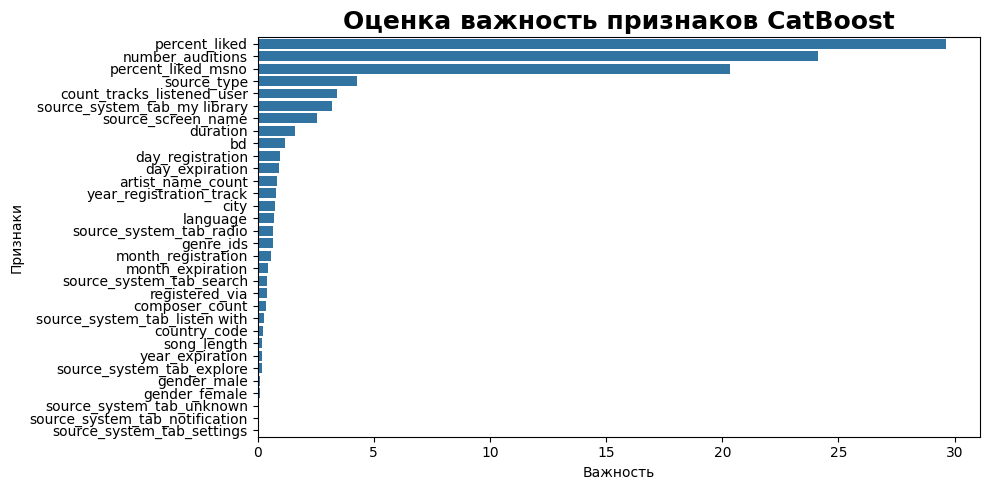

In [122]:
# Оценка важности признаков
feature_importance = catboost.feature_importances_
feature_names = X.columns

importance = pd.DataFrame()
importance.index = feature_names
importance['Важность'] = feature_importance
importance = importance.sort_values(by = 'Важность', ascending = False)

fig1 = plt.subplots(figsize = (10,5))
sns.barplot(data = importance,
            y = importance.index,
            x = 'Важность')

plt.ylabel('Признаки')
plt.title('Оценка важность признаков CatBoost')
plt.tight_layout()
plt.show()

- Самым важным параметром для модели - являются percent_liked, number_auditions, percent_liked_msno - эти принаки - новые фичи, которые добавились в процессе работы с данными
- source_system_tab_unknown, source_system_tab_notification, source_system_tab_settings, gender_female, gender_male, являются неважными для модели - поэтому удалим эти признаки и натренируем модель на полном наборе данных

In [132]:
df.drop(['source_system_tab_unknown',
         'source_system_tab_notification',
         'source_system_tab_settings',
         'gender_female',
         'gender_male'],
         axis = 1, inplace = True)

### Трениировка на полном наборе данных

In [134]:
X = df.drop('target', axis = 1)
y = df['target']

full_pool = Pool(data = X, label = y)

print('\nFull Data Pool\n', full_pool.shape)


Full Data Pool
 (6779782, 27)


In [136]:
catboost = CatBoostClassifier()

catboost.fit(full_pool,
             verbose = 200,
             plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.445516
0:	learn: 0.6219199	total: 338ms	remaining: 5m 38s
200:	learn: 0.5516418	total: 1m 2s	remaining: 4m 8s
400:	learn: 0.5464900	total: 2m 3s	remaining: 3m 4s
600:	learn: 0.5424452	total: 3m 6s	remaining: 2m 4s
800:	learn: 0.5391282	total: 4m 10s	remaining: 1m 2s
999:	learn: 0.5361257	total: 5m 13s	remaining: 0us


In [137]:
joblib.dump(catboost, 'catboost.pkl')

['catboost.pkl']

In [138]:
df.head(2)

city    bd  registered_via  month_registration  day_registration  \
0     1   0.0               7                   1                 2   
1    13  24.0               9                   5                25   

   year_expiration  month_expiration  day_expiration  duration  \
0             2017                10               5      2103   
1             2017                 9              11      2301   

   percent_liked_msno  ...  country_code  year_registration_track  \
0           50.644166  ...            31                       16   
1           74.276527  ...           101                       99   

   percent_liked  number_auditions  target  source_system_tab_explore  \
0      45.733788               293       1                        1.0   
1     100.000000                 1       1                        0.0   

   source_system_tab_listen with  source_system_tab_my library  \
0                            0.0                           0.0   
1                            0.0                           1.0   

   source_system_tab_radio  source_system_tab_search  
0                      0.0                       0.0  
1                      0.0                       0.0  

[2 rows x 28 columns]

# Функция обработки набора данных

In [170]:
def processing(data):
    """
    data: набор данных, для обработки
    """
    # Если есть некорректные значения в наборе данных - то заменяем их медианой (исправляем)
    if data[(data['bd'] >= 100) | (data['bd'] < 0)]['bd'].nunique() > 0:
        data.loc[(data['bd'] >= 100) | (data['bd'] < 0), 'bd'] = np.nan
        # Медианное значение
        median = data[(data['bd'] > 0) & (data['bd'] < 100)]['bd'].median()

        # Заменяем некорректные значения - медианным
        data['bd'] = data['bd'].fillna(median)


    
    # Замена пропусков в категориальных признаках на значение 'unknown'
    # список признаков - в которых значения NaN заменяются на unknown
    columns_unknown = ['gender', 'name', 'genre_ids', 'artist_name', 'composer', 'isrc', 
                   'lyricist', 'source_system_tab', 'source_screen_name', 'source_type']
    # Цикл замены значений
    for col in columns_unknown:
        data[col] = data[col].fillna('unknown')


    
    # Замена пропусков в числовых признаках на значение 0
    zero_columns = ['song_length', 'language']
    # Цикл для заполнения
    for col in zero_columns:
        data[col] = data[col].fillna(0)


    
    # Разбиение признака registration_init_time
    # Преобразуем столбцы в тип данных datetime для извлечения признаков год, месяц и время
    data['registration_init_time'] = pd.to_datetime(data['registration_init_time'], format='%Y%m%d')
    data['expiration_date'] = pd.to_datetime(data['expiration_date'], format='%Y%m%d')
    
    # первое значение - индекс, перед которым надо вставить признак
    data.insert(5 , 'year_registration', data['registration_init_time'].dt.year) 
    data.insert(6 , 'month_registration', data['registration_init_time'].dt.month)
    data.insert(7 , 'day_registration', data['registration_init_time'].dt.day)
    # Удаление столбца registration_init_time 
    data.drop('registration_init_time', axis = 1, inplace = True)

    # Разбиение признака expiration_date
    data.insert(8 , 'year_expiration', data['expiration_date'].dt.year)
    data.insert(9 , 'month_expiration', data['expiration_date'].dt.month)
    data.insert(10 , 'day_expiration', data['expiration_date'].dt.day)
    # Удаление столбца expiration_date
    data.drop('expiration_date', axis = 1, inplace = True)


    
    # Разбиение признака iscr
    # Извлекаем код страны - значения которые буду вставлять
    country_value = data[data['isrc']\
                               .apply(lambda x: len(x)) == 12]['isrc']\
                               .apply(lambda x: str(x)[:2]).values
    # Извлекаем индексы - места на которые вставлять значения, так как в данных есть значения unknown - из которых не надо ничего извлекать
    country_index = data[data['isrc']\
                               .apply(lambda x: len(x)) == 12]['isrc']\
                               .apply(lambda x: str(x)[:2]).index
    # Добавляем значение кода страны как новый столбец
    data.loc[country_index, 'country_code'] = country_value
    
    # Извлекаем год регистрации трека - значения которые буду вставлять
    year_value = data[data['isrc']\
                               .apply(lambda x: len(x)) == 12]['isrc']\
                               .apply(lambda x: str(x)[5:7]).values
    # Извлекаем индекс для записи в определенные строки в наборе данных 
    year_index = data[data['isrc']\
                               .apply(lambda x: len(x)) == 12]['isrc']\
                               .apply(lambda x: str(x)[5:7]).index
    # Добавляем значение года регистрации как новый столбец
    data.loc[year_index, 'year_registration_track'] = year_value
    # Удаление признака iscr
    data.drop('isrc', axis = 1, inplace = True)
    # Заполнение NaN значений значениями 'unknown' - появились значения NaN после рабзбиения признака
    # Список из признаков, в которых надо заполнить значения NaN
    fill_columns = ['country_code', 'year_registration_track']
    
    # Цикл для заполнения значений NaN значением unknown
    for col in fill_columns:
        data[col] = data[col].fillna('unknown')


    
    # song_length - переведем в секнды (поменяем единицу измерения из мс - в сек)
    data['song_length'] = data['song_length'] / 1000
    # year_registration_track поменяем тип данных - на int
    # заменим значения unknown на -1
    data['year_registration_track'] = data['year_registration_track'].replace('unknown', '-1')
    # преобразуем в тип данных int
    data['year_registration_track'] = data['year_registration_track'].astype('int')



    # Добавление признака длительность нахождения на платформе
    # Создание таблицы для даты регистрации и даты удаления аккаунта 
    duration = pd.DataFrame()
    
    #Из 3х столбцов преобразуем в один с типом данных datetime - дата регистрации 
    duration['Дата_регистрации'] = pd.to_datetime(data['year_registration']*10000\
                                                 + data['month_registration']*100\
                                                 + data['day_registration'],\
                                                 format='%Y%m%d')
    # Тоже самое - только дата удаления аккаунта 
    duration['Дата_удаления_аккаунта'] = pd.to_datetime(data['year_expiration']*10000\
                                                    + data['month_expiration']*100\
                                                    + data['day_expiration'],\
                                                    format='%Y%m%d')
    
    # Добавление разницы между днем регистрации и днем удаления аккаунта - это будет длительность нахождения на платформе
    duration['Длительность'] = (duration['Дата_удаления_аккаунта'] - duration['Дата_регистрации']).dt.days.astype(int)
    
    # Индексы в которых отрицаиельноые значения длительности
    index = duration[duration['Длительность'] < 0].index
    # Удаляем индексы, в которых отрицательные значения продолжительности (в основном наборе данных)
    data = data.drop(index)
    
    # Вставляем перед 11 индексом значение длительности нахождения на платформе в основной набор данных
    data.insert(11, column = 'duration', value = duration['Длительность'])



    # Замена выбросов в столбце song_length - время прослушивания
    # Находим 25 процентиль столбца song_length
    q1 = data['song_length'].quantile(0.25)
    # Находим 75 процентиль
    q3 = data['song_length'].quantile(0.75)
    
    # Считаем разницу между 3 и 1 значением
    iqr = q3 - q1
    # Нижняя граница 
    lower_bound = q1 - 1.5 * iqr
    # Верхняя граница 
    upper_bound = q3 + 1.5 * iqr
    
    # Значения которые надо заменить
    indexes_to_replace = data[(data['song_length'] < lower_bound) | (data['song_length'] > upper_bound)].index
    # Медианное значение 
    median_value = data['song_length'].median()
    # Замена выбросов на медианное значение
    data.loc[indexes_to_replace, 'song_length'] = median_value

   

    # Добавление нового столбца - насколько нравится песня (в процентах)
    # Группировка по количеству прослушиваний и количеству лайков 
    song_id = data.groupby('name').agg({'target' : ['count', 'sum']})['target']
    song_id.index.name = None
    # Создание нового столбца - для отображения процента релевантности
    song_id['%'] = (song_id['sum'] / song_id['count']) * 100
    
    # Создание столбца - процент лайков
    data['percent_liked'] = data['name'].map(song_id['%'])

    # Создание столбца - количество раз сколько прослушали определенный трек
    data['number_auditions'] = data['name'].map(song_id['count'])



    # Добавление значения процент песен, который нравится пользователю
    # Объединяем и считаем сколько всего прослушиваний у пользователя и сколько он лайкает треков
    msno_song_count = data.groupby('msno').agg({'target' : ['count', 'sum']})['target']
    # Удаление названия индекса 
    msno_song_count.index.name = None
    msno_song_count['%'] = (msno_song_count['sum'] / msno_song_count['count']) * 100

    # Создание столбца - процент лайков пользователем
    data['percent_liked_msno'] = data['msno'].map(msno_song_count['%'])

    # Создание столбца - Количество прослушанных треков пользователем
    data['count_tracks_listened_user'] = data['msno'].map(msno_song_count['count'])

    # Количество прослушиваний определенного пользователя
    artist_name_count = data.groupby('artist_name').agg({'target' : 'count'})
    # Добавление нового признака
    data['artist_name_count'] = data['artist_name'].map(artist_name_count['target'])

    # Количество прослушиваний composer
    composer_count = data.groupby('composer').agg({'target' : 'count'})
    # Добавление нового признака
    data['composer_count'] = data['composer'].map(composer_count['target'])

    # Количество прослушиваний lyricist
    lyricist_count = data.groupby('lyricist').agg({'target' : 'count'})
    # Добавление нового признака
    data['lyricist_count'] = data['lyricist'].map(lyricist_count['target'])

    # Удаление столбцов, из которых мы получили новые значения
    data.drop(['artist_name', 'composer', 'lyricist'], axis = 1, inplace = True)

    # Порядок столбцов 
    order = ['msno', 'city', 'bd', 'gender', 'registered_via', 'year_registration',
             'month_registration', 'day_registration', 'year_expiration',
             'month_expiration', 'day_expiration', 'duration', 'percent_liked_msno', 'count_tracks_listened_user',
             'song_id', 'name', 'song_length', 'genre_ids', 'artist_name_count', 'composer_count', 
             'lyricist_count', 'language', 'source_system_tab', 'source_screen_name', 'source_type', 
             'country_code', 'year_registration_track', 'percent_liked', 'number_auditions', 'target']

    data = data[order]
    
    data.drop('name', axis = 1, inplace = True)
    data.index = range(0,len(data))
    
    # Кодирование категориальных признаков
    # столбцы для кодирования OHE
    ohe_columns = ['gender', 'source_system_tab']
    
    # Загрузка кодировщика
    ohe = joblib.load('OHEncodeer.pkl')
    # кодирование столбцов
    ohe_data = ohe.transform(data[ohe_columns])
    ohe_data = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))
    
    data = pd.concat([data,ohe_data], axis = 1)
    data.drop(['gender', 'source_system_tab'], axis = 1, inplace = True)
    data.drop(['msno', 'song_id'], axis = 1, inplace = True)

    # Кодирование LabelEncoder
    # Загрузка кодировщиков 
    genre_ids_encoder = joblib.load('genre_ids_encoder.pkl')
    source_screen_name_encoder = joblib.load('source_screen_name_encoder.pkl')
    source_type_encoder = joblib.load('source_type_encoder.pkl')
    country_code_encoder = joblib.load('country_code_encoder.pkl')

    # Кодирование 
    data['genre_ids'] = genre_ids_encoder.fit_transform(data['genre_ids'])
    data['source_screen_name'] = source_screen_name_encoder.fit_transform(data['source_screen_name'])
    data['source_type'] = source_type_encoder.fit_transform(data['source_type'])
    data['country_code'] = country_code_encoder.fit_transform(data['country_code'])

    # Удаление столбцов мультиколлинеарных 
    data.drop(['gender_unknown', 'year_registration', 'lyricist_count', 'source_system_tab_discover'], axis = 1, inplace = True)
    # Удаление столбцов, которые незначительные для тренировки модели
    data.drop(['source_system_tab_unknown',
         'source_system_tab_notification',
         'source_system_tab_settings',
         'gender_female',
         'gender_male'],
         axis = 1, inplace = True)
    return data

### Применение функции

In [171]:
# Объединение наборов данных в один набор данных
# Дополним набор данных признаками песен (дополнительные данных из файла songs.csv)
data = pd.merge(df_train,df_songs, on = 'song_id', how = 'left')

# Дополним набор данных признаками пользователя (дополнительные данные из файла members.csv)
data = pd.merge(data, df_members, on = 'msno', how = 'left')

# Дополним набор данных названием и кодом isrc песни (дополнительные данные из файла song_extra_info.csv)
data = pd.merge(data, df_song_extra, on = 'song_id', how = 'left')

# Просмотр набора данных
print(f'Размер дополненного набора данных: {data.shape}')
data.head(2)

Размер дополненного набора данных: (7377418, 20)


msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist       1     206471.0       359   
1  Local playlist more   local-playlist       1     284584.0      1259   

       artist_name              composer lyricist  language  city  bd  gender  \
0         Bastille  Dan Smith| Mark Crew      NaN      52.0     1   0     NaN   
1  Various Artists                   NaN      NaN      52.0    13  24  female   

   registered_via  registration_init_time  expiration_date  \
0               7                20120102         20171005   
1               9                20110525         20170911   

                 name          isrc  
0          Good Grief  GBUM71602854  
1  Lords of Cardboard  US3C69910183

In [172]:
data = processing(data)

In [173]:
df.head(2)

city    bd  registered_via  month_registration  day_registration  \
0     1   0.0               7                   1                 2   
1    13  24.0               9                   5                25   

   year_expiration  month_expiration  day_expiration  duration  \
0             2017                10               5      2103   
1             2017                 9              11      2301   

   percent_liked_msno  ...  country_code  year_registration_track  \
0           50.644166  ...            31                       16   
1           74.276527  ...           101                       99   

   percent_liked  number_auditions  target  source_system_tab_explore  \
0      45.733788               293       1                        1.0   
1     100.000000                 1       1                        0.0   

   source_system_tab_listen with  source_system_tab_my library  \
0                            0.0                           0.0   
1                            0.0                           1.0   

   source_system_tab_radio  source_system_tab_search  
0                      0.0                       0.0  
1                      0.0                       0.0  

[2 rows x 28 columns]

In [174]:
data.head(2)

city    bd  registered_via  month_registration  day_registration  \
0     1   0.0               7                   1                 2   
1    13  24.0               9                   5                25   

   year_expiration  month_expiration  day_expiration  duration  \
0             2017                10               5      2103   
1             2017                 9              11      2301   

   percent_liked_msno  ...  country_code  year_registration_track  \
0           50.644166  ...            31                       16   
1           74.276527  ...           101                       99   

   percent_liked  number_auditions  target  source_system_tab_explore  \
0      45.733788               293       1                        1.0   
1     100.000000                 1       1                        0.0   

   source_system_tab_listen with  source_system_tab_my library  \
0                            0.0                           0.0   
1                            0.0                           1.0   

   source_system_tab_radio  source_system_tab_search  
0                      0.0                       0.0  
1                      0.0                       0.0  

[2 rows x 28 columns]

In [176]:
df.columns == data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

- После проверки набора данных, который мы обрабатывали в процессе с тем, коорый получился после функции обработки нбора данных - мы получили одинаковые наборы, следовательно функцию можно применять для подготовки набора данных для предсказания на признаках

# Подготовка тестового набора данных
___
Так как после разделения наборов данных - удаляли незначимые столбцы для модели - удалим эти данные из набора данных

In [182]:
test.head(2)

msno  city    bd  registered_via  \
60  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   
61  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   

    month_registration  day_registration  year_expiration  month_expiration  \
60                   6                26             2017                 9   
61                   6                26             2017                 9   

    day_expiration  duration  ...  gender_female  gender_male  \
60              13      1175  ...            0.0          1.0   
61              13      1175  ...            0.0          1.0   

   source_system_tab_explore  source_system_tab_listen with  \
60                       0.0                            0.0   
61                       0.0                            0.0   

    source_system_tab_my library  source_system_tab_notification  \
60                           1.0                             0.0   
61                           1.0                             0.0   

    source_system_tab_radio  source_system_tab_search  \
60                      0.0                       0.0   
61                      0.0                       0.0   

    source_system_tab_settings  source_system_tab_unknown  
60                         0.0                        0.0  
61                         0.0                        0.0  

[2 rows x 35 columns]

In [183]:
test.drop(['source_system_tab_unknown',
         'source_system_tab_notification',
         'source_system_tab_settings',
         'gender_female',
         'gender_male'],
         axis = 1, inplace = True)

In [185]:
test.head(2)

msno  city    bd  registered_via  \
60  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   
61  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   

    month_registration  day_registration  year_expiration  month_expiration  \
60                   6                26             2017                 9   
61                   6                26             2017                 9   

    day_expiration  duration  ...  country_code  year_registration_track  \
60              13      1175  ...           101                       15   
61              13      1175  ...           101                       15   

   percent_liked  number_auditions  target  source_system_tab_explore  \
60     55.840456               351       1                        0.0   
61     50.936330               267       1                        0.0   

    source_system_tab_listen with  source_system_tab_my library  \
60                            0.0                           1.0   
61                            0.0                           1.0   

    source_system_tab_radio  source_system_tab_search  
60                      0.0                       0.0  
61                      0.0                       0.0  

[2 rows x 30 columns]

- Остались индексы человека, для которого будем делать рекомендации и индексы песен (чтобы высвечивать индексы понравившихся песен)

# Создадим таблицу для записи результатов модели (на тестовом наборе данных)

In [204]:
# Создание набора данных для записи результатов
submission = pd.DataFrame()

# Добавляем id пользователя
submission['id_user'] = test['msno']
# Добавляем id трека 
submission['id_track'] = test['song_id']
# Столбец истинных меток, для проверки метрики
submission['y_true'] = test['target']

submission.index = range(0, len(submission))

# Размер набора данных (должен быть равен test.shape[0])
print(submission.shape)
submission.head()

(597633, 3)


id_user  \
0  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
1  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
2  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
3  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
4  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   

                                       id_track  y_true  
0  1R5HlX765HuV3uvLmJ0FqUQmlAmjdcqF0GbOqf9qUGs=       1  
1  hQtwwQhSamcIwNl/1JDR3B77oF2QxwB95paAKAqsIAo=       1  
2  RAVcXkNI6tqrsArzBxA9JcNnv/ftDwqDwBDaGqIzXyA=       1  
3  ziioVtzot6FMViJgAMZliplvo7EmX3ecPuoZHXTr2Zo=       1  
4  pRjhEkL8Da3+YpKh9SYcmYLKG1lYFy4ixcYy0h1Pc30=       1

In [206]:
test.shape[0] == submission.shape[0]

True

In [210]:
submission['id_user'].nunique()

2000

Для проверки метрики nDCG@20 - взял 2000 уникальных пользователей, которые послушали больше 20 треков на платформе

### Предсказание на тестовом наборе данных

In [209]:
# Изменение нумерации индексов
test.index = range(0, len(test))
test.head(2)

msno  city    bd  registered_via  \
0  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   
1  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=    13  28.0               3   

   month_registration  day_registration  year_expiration  month_expiration  \
0                   6                26             2017                 9   
1                   6                26             2017                 9   

   day_expiration  duration  ...  country_code  year_registration_track  \
0              13      1175  ...           101                       15   
1              13      1175  ...           101                       15   

  percent_liked  number_auditions  target  source_system_tab_explore  \
0     55.840456               351       1                        0.0   
1     50.936330               267       1                        0.0   

   source_system_tab_listen with  source_system_tab_my library  \
0                            0.0                           1.0   
1                            0.0                           1.0   

   source_system_tab_radio  source_system_tab_search  
0                      0.0                       0.0  
1                      0.0                       0.0  

[2 rows x 30 columns]

In [213]:
# Удалим столбцы msno, song_id, так как они нужны были для индексов нового набора (submission)
# Так же удаляем target, так как он нужен только для проверки - а мы его перенесли в новый набор данных
test.drop(['msno', 'song_id', 'target'], axis = 1, inplace = True)

In [216]:
# Загрузка натренированной модели
model = joblib.load('catboost.pkl')

In [223]:
test_prob = model.predict_proba(test)[:, 1]

In [226]:
test_pred = model.predict(test)

In [225]:
# Добавляем вероятности в таблицу submission
submission['test_prod'] = test_prob
submission.head()

id_user  \
0  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
1  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
2  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
3  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
4  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   

                                       id_track  y_true  test_prod  
0  1R5HlX765HuV3uvLmJ0FqUQmlAmjdcqF0GbOqf9qUGs=       1   0.560543  
1  hQtwwQhSamcIwNl/1JDR3B77oF2QxwB95paAKAqsIAo=       1   0.527425  
2  RAVcXkNI6tqrsArzBxA9JcNnv/ftDwqDwBDaGqIzXyA=       1   0.896399  
3  ziioVtzot6FMViJgAMZliplvo7EmX3ecPuoZHXTr2Zo=       1   0.858443  
4  pRjhEkL8Da3+YpKh9SYcmYLKG1lYFy4ixcYy0h1Pc30=       1   0.845846

In [227]:
# Добавляем предсказание в таблицу submission для проверки точности
submission['test_pred'] = test_pred
submission.head()

id_user  \
0  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
1  B/wRgN7GRfDNGvsvjoA97MIFvlNkx52eMz8rGhK/P9M=   
2  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
3  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   
4  yABGsFFqTctk/xnMj67nHmnisCwdue7XYxkYGOe9BGE=   

                                       id_track  y_true  test_prod  test_pred  
0  1R5HlX765HuV3uvLmJ0FqUQmlAmjdcqF0GbOqf9qUGs=       1   0.560543          1  
1  hQtwwQhSamcIwNl/1JDR3B77oF2QxwB95paAKAqsIAo=       1   0.527425          1  
2  RAVcXkNI6tqrsArzBxA9JcNnv/ftDwqDwBDaGqIzXyA=       1   0.896399          1  
3  ziioVtzot6FMViJgAMZliplvo7EmX3ecPuoZHXTr2Zo=       1   0.858443          1  
4  pRjhEkL8Da3+YpKh9SYcmYLKG1lYFy4ixcYy0h1Pc30=       1   0.845846          1

In [229]:
print(classification_report(submission['y_true'], submission['test_pred']))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69    292116
           1       0.71      0.71      0.71    305517

    accuracy                           0.70    597633
   macro avg       0.70      0.70      0.70    597633
weighted avg       0.70      0.70      0.70    597633



- Точность предсказания модели на тестовом наборе данных = 70%
- Мы получили вероятности - насколько нравится пользователю определенный трек (и у нас есть истинные метки и предсказанные вероятности)
- Далее надо сгруппировать пользователей по индексам (чтобы у каждого пользователя были следующие значения - список истинных меток, и списокмпредсказанных меток)
- Оценить метрику nDCG@20 - по 20 первым трекам

### Для каждого пользователя создадим списки с релевантностью

In [308]:
# Группировка данных по 'id_user' и объединение в один набор данных
grouped = submission.groupby('id_user').apply(lambda x: x.sort_values(by='test_prod', ascending=False))

# Сброс индекса после объединения
grouped.reset_index(drop=True, inplace=True)

# Создание набора данных с уникальными значениями пользователей для проверки метрики
ndcg_data = pd.DataFrame({
    'id_user': grouped['id_user'].unique(),
    'relevance_true': grouped.groupby('id_user')['y_true'].apply(list).values,
    'relevance_pred': grouped.groupby('id_user')['test_pred'].apply(list).values
})
ndcg_data.head()

id_user  \
0  +0CxUZKWtmqPKlW+2VF+hY2rfq+Dh9JM/AqoZJnCr4E=   
1  +1a0wTElsAMdYysWZk1uBxeLnjxIc4vB2EznisNlpVw=   
2  +2XBp2p9atTpyVPWac3SEEW41i8Xrnl7Utl/h8T4iOo=   
3  +3TmD1r1LdFDR8jzo4xb+Ra2xio/GLHt3JE1b1sYPAU=   
4  +3fHO3QeeQv8IY1RptwnwKpCjwnUOBX+U67hoFXDYmQ=   

                                      relevance_true  \
0  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...   
1  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
2  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...   
4  [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...   

                                      relevance_pred  
0  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

- Теперь у нас есть списки для каждого пользователя с лучшей релевантностью и с истинной релевантностью
- проверим метрику модели nDCG@20 - по первым 20 значениям

### Подсчет метрики nDCG@20

In [318]:
ndcg_scores = []
for i in range(len(ndcg_data)):
    true_relevance = ndcg_data.loc[i, 'relevance_true']
    pred_relevance = ndcg_data.loc[i, 'relevance_pred']
    # Вычисление nDCG@20 для текущего пользователя
    ndcg = ndcg_score([true_relevance], [pred_relevance], k=20)
    ndcg_scores.append(ndcg)

# Среднее значение метрики nDCG@20 по всем пользователям
mean_ndcg = np.mean(ndcg_scores)
print("Среднее значение nDCG@20 по 2000 пользователям:", round(mean_ndcg,5))

Среднее значение nDCG@20 по 2000 пользователям: 0.60384


- Метрика nDCG@20 (Normalized Discounted Cumulative Gain at 20) измеряет качество ранжирования элементов в рекомендательных системах.
- Значения метрики nDCG@20 находятся в интервале от 0 до 1, чем ближе к 1, тем лучше качество ранжирования
- Метрику можно интерпретировать как точность рекомендации
- Мое значение метрики = 0.6 -> модель на 60% точно ранжирует по релевантности треков